This script is designed to quantify similarities and differences between two aspects of the visual pathway in object recognition.

DICE COEEFICIENT 

In [6]:
# calculate dice coefficient between pIPS and LO FC maps
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image
import matplotlib.pyplot as plt

# Define study directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
group_out_dir = f'{results_dir}/group_averages'

def dice_coefficient(img1, img2):
    """Calculate Dice coefficient between two binary images."""
    # Get data arrays and ensure binary
    img1_data = (img1.get_fdata() > 0).astype(int)
    img2_data = (img2.get_fdata() > 0).astype(int)
    
    # Calculate intersection
    intersection = np.sum(img1_data * img2_data)
    
    # Calculate Dice using standard formula: 2*intersection/(sum of elements)
    dice = 2.0 * intersection / (np.sum(img1_data) + np.sum(img2_data))
    
    return dice

def main():
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    analysis_type = 'fc'  # Using fc as specified in your goal
    
    # Create a results table
    results = []
    
    # Compare across hemispheres
    for hemi in hemispheres:
        # Load images
        pips_img_path = f'{group_out_dir}/pIPS_{hemi}_{analysis_type}_thresh.nii.gz'
        lo_img_path = f'{group_out_dir}/LO_{hemi}_{analysis_type}_thresh.nii.gz'
        
        # Check if files exist
        if not os.path.exists(pips_img_path):
            print(f"Warning: File not found - {pips_img_path}")
            continue
            
        if not os.path.exists(lo_img_path):
            print(f"Warning: File not found - {lo_img_path}")
            continue
            
        # Both files exist, proceed with analysis
        pips_img = nib.load(pips_img_path)
        lo_img = nib.load(lo_img_path)
        
        # Calculate Dice coefficient
        dice_score = dice_coefficient(pips_img, lo_img)
        
        results.append({
            'Hemisphere': hemi,
            'ROI1': 'pIPS',
            'ROI2': 'LO',
            'Dice': dice_score
        })
        
        print(f"Dice coefficient for {hemi} hemisphere, pIPS vs LO: {dice_score:.4f}")
    
    # Check if we have any results
    if not results:
        print("No results were calculated. Please check if the input files exist.")
        return None
    
    # Convert results to DataFrame for easy viewing
    results_df = pd.DataFrame(results)
    print("\nResults summary:")
    print(results_df)
    
    # Create a simple bar plot of results
    plt.figure(figsize=(8, 6))
    bars = plt.bar(
        [f"{r['Hemisphere']} hemisphere" for r in results],
        [r['Dice'] for r in results]
    )
    plt.title('Dice Coefficient Between pIPS and LO FC Maps')
    plt.ylabel('Dice Coefficient')
    plt.ylim(0, 1)  # Dice coef ranges from 0-1
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.01,
            f'{height:.4f}',
            ha='center', va='bottom'
        )
    
    # Save plot
    plot_path = f'{results_dir}/pIPS_LO_dice_comparison.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {plot_path}")
    plt.close()
    
    return results_df

if __name__ == "__main__":
    results = main()

Dice coefficient for left hemisphere, pIPS vs LO: 0.6965
Dice coefficient for right hemisphere, pIPS vs LO: 0.6930

Results summary:
  Hemisphere  ROI1 ROI2      Dice
0       left  pIPS   LO  0.696452
1      right  pIPS   LO  0.692965
Saved plot to: /user_data/csimmon2/git_repos/ptoc/results/pIPS_LO_dice_comparison.png



ANALYSIS TYPE: FC

Left hemisphere analysis (fc):
Dice coefficient: 0.6965
pIPS only: 13341 voxels (32.4%)
LO only: 5832 voxels (14.2%)
Overlap: 21995 voxels (53.4%)

Right hemisphere analysis (fc):
Dice coefficient: 0.6930
pIPS only: 13908 voxels (34.6%)
LO only: 4982 voxels (12.4%)
Overlap: 21317 voxels (53.0%)

ANALYSIS TYPE: PPI

Left hemisphere analysis (ppi):
Dice coefficient: 0.7870
pIPS only: 2406 voxels (13.1%)
LO only: 4051 voxels (22.0%)
Overlap: 11926 voxels (64.9%)

Right hemisphere analysis (ppi):
Dice coefficient: 0.7056
pIPS only: 7619 voxels (31.9%)
LO only: 3248 voxels (13.6%)
Overlap: 13025 voxels (54.5%)

FC Results summary:
  Analysis Hemisphere      Dice  pIPS_only  LO_only  Overlap  Total  \
0       fc       left  0.696452      13341     5832    21995  41168   
1       fc      right  0.692965      13908     4982    21317  40207   

   pIPS_only_pct  LO_only_pct  Overlap_pct  
0      32.406238    14.166343    53.427419  
1      34.590992    12.390877    53.018131

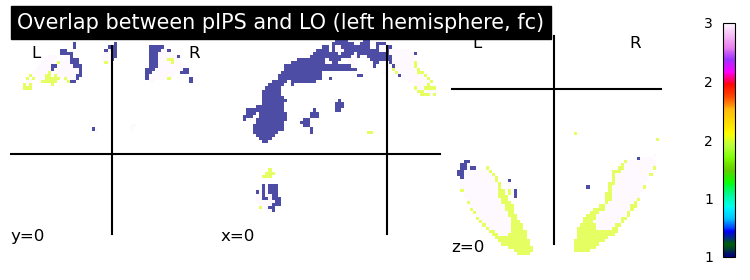

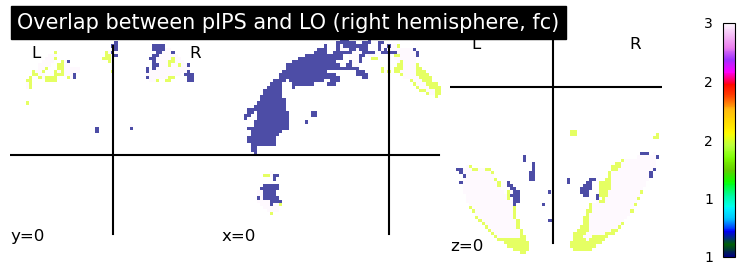

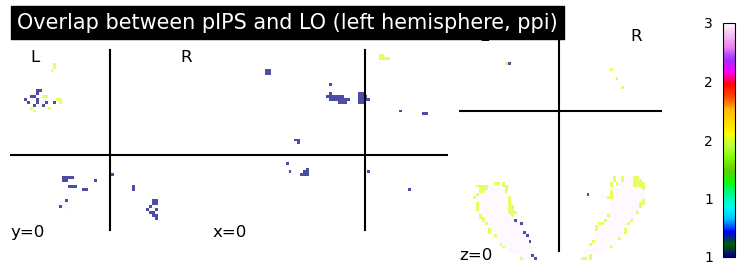

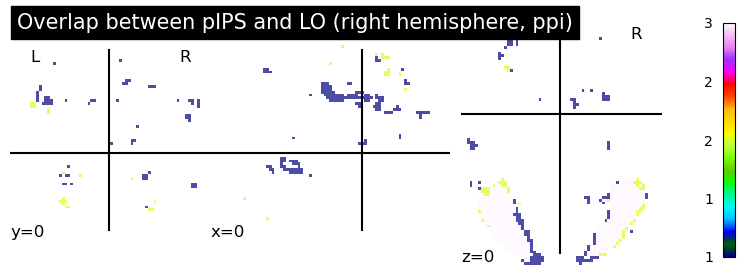

In [9]:
# Break down the overlap between pIPS and LO for review of results
## add PPI
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting

# Define study directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
group_out_dir = f'{results_dir}/group_averages'

def dice_coefficient(img1, img2):
    """Calculate Dice coefficient between two binary images."""
    # Get data arrays and ensure binary
    img1_data = (img1.get_fdata() > 0).astype(int)
    img2_data = (img2.get_fdata() > 0).astype(int)
    
    # Calculate intersection
    intersection = np.sum(img1_data * img2_data)
    
    # Calculate Dice using standard formula: 2*intersection/(sum of elements)
    dice = 2.0 * intersection / (np.sum(img1_data) + np.sum(img2_data))
    
    return dice, img1_data, img2_data

def main():
    # Define hemispheres and analysis types
    hemispheres = ['left', 'right']
    analysis_types = ['fc', 'ppi']
    
    # Create results tables
    results = []
    
    # Loop through analysis types
    for analysis_type in analysis_types:
        print(f"\n{'='*50}")
        print(f"ANALYSIS TYPE: {analysis_type.upper()}")
        print(f"{'='*50}")
        
        # Compare across hemispheres
        for hemi in hemispheres:
            # Load images
            pips_img_path = f'{group_out_dir}/pIPS_{hemi}_{analysis_type}_thresh.nii.gz'
            lo_img_path = f'{group_out_dir}/LO_{hemi}_{analysis_type}_thresh.nii.gz'
            
            # Check if files exist
            if not os.path.exists(pips_img_path) or not os.path.exists(lo_img_path):
                print(f"Warning: Files not found for {hemi} hemisphere, {analysis_type}. Skipping.")
                continue
                
            # Load images
            pips_img = nib.load(pips_img_path)
            lo_img = nib.load(lo_img_path)
            
            # Calculate Dice coefficient
            dice_score, pips_data, lo_data = dice_coefficient(pips_img, lo_img)
            
            # Create overlap map (1=pIPS only, 2=LO only, 3=overlap)
            overlap_data = np.zeros_like(pips_data)
            overlap_data[pips_data == 1] = 1  # pIPS only
            overlap_data[lo_data == 1] = 2    # LO only
            overlap_data[(pips_data == 1) & (lo_data == 1)] = 3  # Overlap
            
            # Count voxels in each category
            pips_only = np.sum(overlap_data == 1)
            lo_only = np.sum(overlap_data == 2)
            overlap_count = np.sum(overlap_data == 3)
            total_voxels = pips_only + lo_only + overlap_count
            
            # Save overlap map
            overlap_img = nib.Nifti1Image(overlap_data, pips_img.affine, pips_img.header)
            overlap_path = f'{results_dir}/pIPS_LO_{hemi}_{analysis_type}_overlap.nii.gz'
            nib.save(overlap_img, overlap_path)
            
            # Create visualization
            display = plotting.plot_roi(
                roi_img=overlap_img,
                bg_img=None,
                display_mode='ortho',
                colorbar=True,
                cut_coords=(0, 0, 0),
                title=f'Overlap between pIPS and LO ({hemi} hemisphere, {analysis_type})'
            )
            display.savefig(f'{results_dir}/pIPS_LO_{hemi}_{analysis_type}_overlap_viz.png', dpi=300)
            
            # Store results
            results.append({
                'Analysis': analysis_type,
                'Hemisphere': hemi,
                'Dice': dice_score,
                'pIPS_only': pips_only,
                'LO_only': lo_only,
                'Overlap': overlap_count,
                'Total': total_voxels,
                'pIPS_only_pct': pips_only/total_voxels*100,
                'LO_only_pct': lo_only/total_voxels*100,
                'Overlap_pct': overlap_count/total_voxels*100
            })
            
            print(f"\n{hemi.capitalize()} hemisphere analysis ({analysis_type}):")
            print(f"Dice coefficient: {dice_score:.4f}")
            print(f"pIPS only: {pips_only} voxels ({pips_only/total_voxels*100:.1f}%)")
            print(f"LO only: {lo_only} voxels ({lo_only/total_voxels*100:.1f}%)")
            print(f"Overlap: {overlap_count} voxels ({overlap_count/total_voxels*100:.1f}%)")
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Print summary by analysis type
    for analysis_type in analysis_types:
        analysis_results = results_df[results_df['Analysis'] == analysis_type]
        if not analysis_results.empty:
            print(f"\n{analysis_type.upper()} Results summary:")
            print(analysis_results)
    
    return results_df

if __name__ == "__main__":
    results = main()

FINGERPRINT CONNECTIVITY

CONSIDER THIS - USE EACH SUBJECTS FUNCTIONAL ROI TO CORRELATE EACH VECTOR....ALSO CONSIDER SCHAEFER 1000 - USE THIS FOR SUBJECT LEVEL COMPARISON.

## don't forget about a noise threshold that vlad mentioned....


=== Step 1: Creating Merged Atlas ===
Loaded pIPS ROI
Loaded LO ROI
Loaded Schaefer atlas with 200 parcels
pIPS overlaps with 28 atlas parcels
  Label 9 (7Networks_LH_Vis_9): 7 voxels
  Label 11 (7Networks_LH_Vis_11): 159 voxels
  Label 12 (7Networks_LH_Vis_12): 2 voxels
  Label 13 (7Networks_LH_Vis_13): 381 voxels
  Label 14 (7Networks_LH_Vis_14): 528 voxels
  Label 33 (7Networks_LH_DorsAttn_Post_3): 554 voxels
  Label 36 (7Networks_LH_DorsAttn_Post_6): 4 voxels
  Label 37 (7Networks_LH_DorsAttn_Post_7): 567 voxels
  Label 38 (7Networks_LH_DorsAttn_Post_8): 64 voxels
  Label 39 (7Networks_LH_DorsAttn_Post_9): 99 voxels
  Label 40 (7Networks_LH_DorsAttn_Post_10): 15 voxels
  Label 62 (7Networks_LH_Cont_Par_2): 269 voxels
  Label 71 (7Networks_LH_Cont_pCun_1): 247 voxels
  Label 80 (7Networks_LH_Default_Par_2): 436 voxels
  Label 82 (7Networks_LH_Default_Par_4): 85 voxels
  Label 99 (7Networks_LH_Default_pCunPCC_4): 5 voxels
  Label 111 (7Networks_RH_Vis_11): 119 voxels
  Label 112 (7N

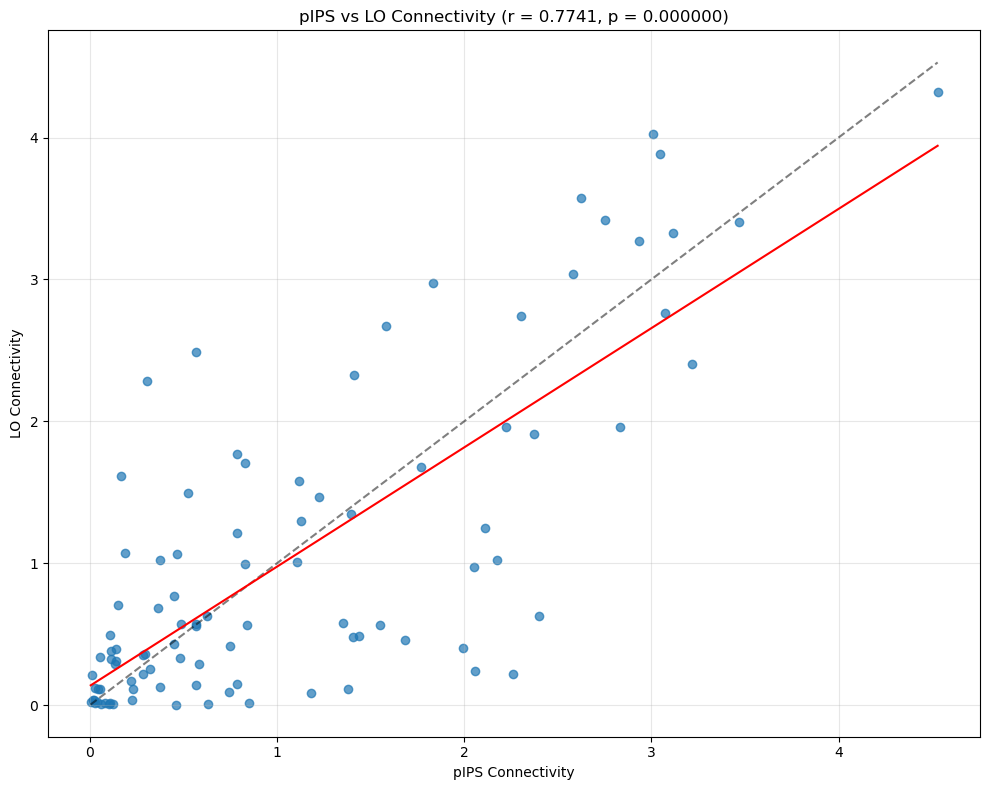

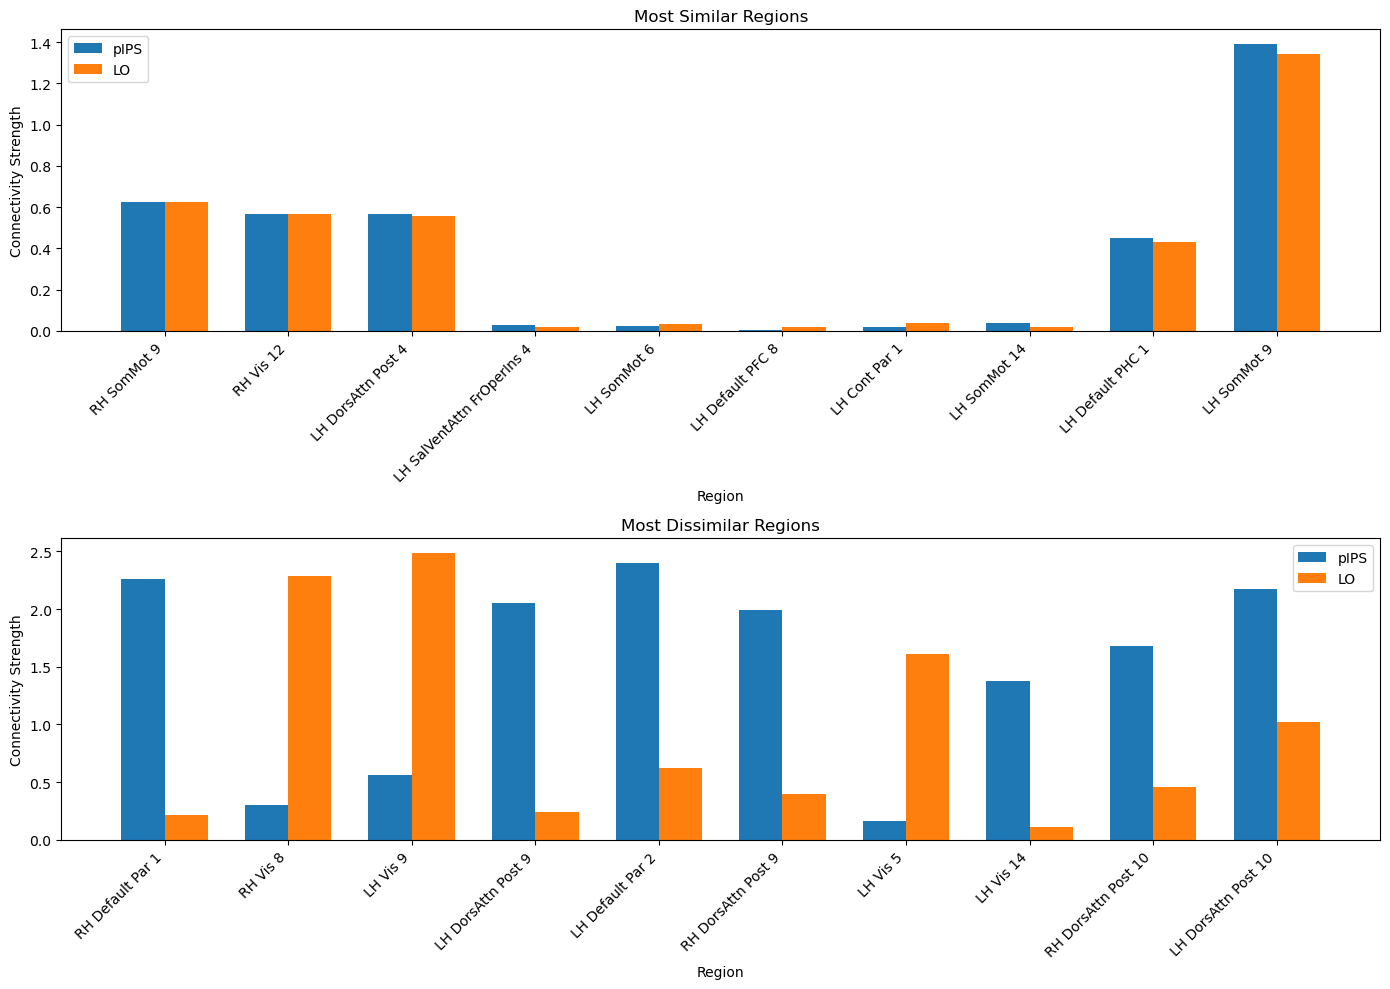

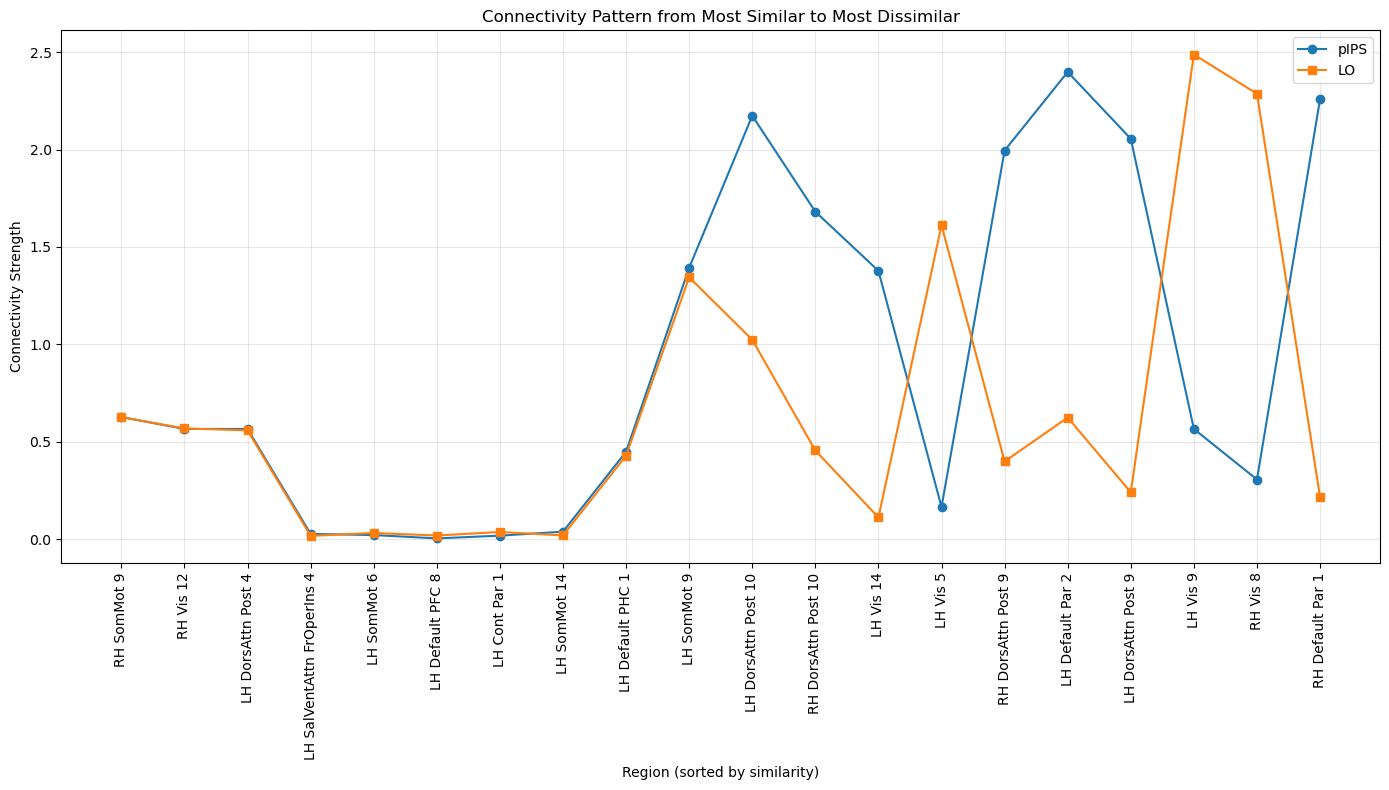

Results visualization complete

=== ANALYSIS SUMMARY ===
Correlation between pIPS and LO connectivity: r = 0.7741, p = 0.000000
Number of regions analyzed: 96


In [37]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
roi_dir = f'{base_dir}/roiParcels'
results_dir = f'{base_dir}/results'
group_out_dir = f'{results_dir}/group_averages'
os.makedirs(results_dir, exist_ok=True)

def create_merged_atlas():
    """
    Create a merged atlas where Wang ROIs replace overlapping regions in Schaefer atlas
    """
    print("\n=== Step 1: Creating Merged Atlas ===")
    
    # Load Wang ROIs - pIPS and LO
    roi_files = {
        'pIPS': f'{roi_dir}/pIPS.nii.gz',
        'LO': f'{roi_dir}/LO.nii.gz'
    }
    
    rois = {}
    for roi_name, roi_path in roi_files.items():
        if os.path.exists(roi_path):
            rois[roi_name] = nib.load(roi_path)
            print(f"Loaded {roi_name} ROI")
        else:
            print(f"Error: ROI file {roi_path} not found!")
            return None
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    atlas_labels = atlas.labels
    print(f"Loaded Schaefer atlas with {len(atlas_labels)} parcels")
    
    # Get atlas data
    atlas_data = atlas_img.get_fdata()
    modified_atlas_data = atlas_data.copy()
    
    # Create a dictionary to store new labels
    new_labels = list(atlas_labels)
    
    # Assign values for new ROIs (continuing from the end of the Schaefer atlas)
    roi_values = {'pIPS': 201, 'LO': 202}
    overlap_info = {}
    
    # Process each ROI
    for roi_name, roi_img in rois.items():
        # Get ROI data and create mask
        roi_data = roi_img.get_fdata()
        roi_mask = roi_data > 0
        
        # Find overlapping parcels
        overlap_mask = (atlas_data > 0) & roi_mask
        overlapping_labels = np.unique(atlas_data[overlap_mask])
        overlapping_labels = overlapping_labels[overlapping_labels > 0]
        
        # Get number of voxels in overlap
        overlap_voxels = {}
        for label in overlapping_labels:
            label_mask = (atlas_data == label) & roi_mask
            overlap_voxels[int(label)] = np.sum(label_mask)
        
        # Store overlap information
        overlap_info[roi_name] = {
            'overlapping_labels': overlapping_labels.tolist(),
            'overlap_voxels': overlap_voxels
        }
        
        print(f"{roi_name} overlaps with {len(overlapping_labels)} atlas parcels")
        for label, voxels in overlap_voxels.items():
            label_idx = int(label) - 1  # Convert to 0-indexed
            if 0 <= label_idx < len(atlas_labels):
                label_name = atlas_labels[label_idx]
                label_name = label_name.decode('utf-8') if isinstance(label_name, bytes) else str(label_name)
                print(f"  Label {label} ({label_name}): {voxels} voxels")
        
        # Remove overlapping parcels from the atlas
        for label in overlapping_labels:
            label_mask = (modified_atlas_data == label) & roi_mask
            modified_atlas_data[label_mask] = 0
        
        # Add ROI with new label
        modified_atlas_data[roi_mask] = roi_values[roi_name]
        
        # Add new label name
        new_labels.append(f"Wang_{roi_name}")
    
    # Create the modified atlas
    modified_atlas_img = nib.Nifti1Image(modified_atlas_data, atlas_img.affine, atlas_img.header)
    merged_atlas_file = f'{results_dir}/schaefer_wang_merged.nii.gz'
    nib.save(modified_atlas_img, merged_atlas_file)
    print(f"Saved merged atlas to: {merged_atlas_file}")
    
    # Save new labels array
    np.save(f'{results_dir}/merged_atlas_labels.npy', new_labels)
    
    # Return atlas information
    return {
        'atlas_img': atlas_img,
        'merged_atlas_img': modified_atlas_img,
        'atlas_labels': atlas_labels,
        'merged_labels': new_labels,
        'roi_values': roi_values,
        'overlap_info': overlap_info
    }

def visualize_merged_atlas(atlas_info):
    """
    Create visualizations of the merged atlas to verify proper integration
    """
    print("\n=== Step 2: Visualizing Merged Atlas ===")
    
    # Original atlas
    atlas_img = atlas_info['atlas_img']
    # Merged atlas
    merged_atlas_img = atlas_info['merged_atlas_img']
    # ROIs
    roi_files = {
        'pIPS': f'{roi_dir}/pIPS.nii.gz',
        'LO': f'{roi_dir}/LO.nii.gz'
    }
    
    # Visualization 1: Original atlas and ROI overlays
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original atlas
    plotting.plot_roi(atlas_img, title="Original Schaefer Atlas", 
                     axes=axes[0], colorbar=True)
    
    # Add pIPS overlay
    p_display = plotting.plot_roi(atlas_img, title="Schaefer + pIPS", 
                                 axes=axes[1], colorbar=True, alpha=0.5)
    p_display.add_overlay(nib.load(roi_files['pIPS']), cmap='Reds', alpha=0.7)
    
    # Add LO overlay
    l_display = plotting.plot_roi(atlas_img, title="Schaefer + LO", 
                                 axes=axes[2], colorbar=True, alpha=0.5)
    l_display.add_overlay(nib.load(roi_files['LO']), cmap='Blues', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/atlas_roi_overlay.png', dpi=300)
    plt.show()
    
    # Visualization 2: Merged atlas
    plt.figure(figsize=(12, 6))
    display = plotting.plot_roi(merged_atlas_img, title="Merged Schaefer-Wang Atlas", 
                               colorbar=True)
    plt.tight_layout()
    plt.savefig(f'{results_dir}/merged_atlas.png', dpi=300)
    plt.show()
    
    # Visualization 3: Slice views comparing original and merged atlas
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Find centers of ROIs for better slice positioning
    pips_img = nib.load(roi_files['pIPS'])
    pips_data = pips_img.get_fdata()
    pips_coords = np.where(pips_data > 0)
    pips_center = [int(np.mean(coord)) for coord in pips_coords]
    
    lo_img = nib.load(roi_files['LO'])
    lo_data = lo_img.get_fdata()
    lo_coords = np.where(lo_data > 0)
    lo_center = [int(np.mean(coord)) for coord in lo_coords]
    
    # Original atlas slices
    plotting.plot_roi(atlas_img, display_mode='x', cut_coords=[pips_center[0]], 
                     title="Original Atlas - Sagittal", axes=axes[0, 0], colorbar=True)
    plotting.plot_roi(atlas_img, display_mode='y', cut_coords=[pips_center[1]], 
                     title="Original Atlas - Coronal", axes=axes[0, 1], colorbar=True)
    plotting.plot_roi(atlas_img, display_mode='z', cut_coords=[pips_center[2]], 
                     title="Original Atlas - Axial", axes=axes[0, 2], colorbar=True)
    
    # Merged atlas slices
    plotting.plot_roi(merged_atlas_img, display_mode='x', cut_coords=[pips_center[0]], 
                     title="Merged Atlas - Sagittal", axes=axes[1, 0], colorbar=True)
    plotting.plot_roi(merged_atlas_img, display_mode='y', cut_coords=[pips_center[1]], 
                     title="Merged Atlas - Coronal", axes=axes[1, 1], colorbar=True)
    plotting.plot_roi(merged_atlas_img, display_mode='z', cut_coords=[pips_center[2]], 
                     title="Merged Atlas - Axial", axes=axes[1, 2], colorbar=True)
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/atlas_comparison_slices.png', dpi=300)
    plt.show()
    
    print("Atlas visualizations complete")

def analyze_connectivity(atlas_info):
    """
    Analyze connectivity using the merged atlas
    """
    print("\n=== Step 3: Analyzing Connectivity with Merged Atlas ===")
    
    # Load FC maps
    try:
        pIPS_img = nib.load(f'{group_out_dir}/pIPS_left_fc_thresh.nii.gz')
        LO_img = nib.load(f'{group_out_dir}/LO_left_fc_thresh.nii.gz')
        print("Successfully loaded FC maps")
    except FileNotFoundError as e:
        print(f"Error: Could not find FC maps: {e}")
        return None
    
    # Create masker using the merged atlas
    merged_atlas_img = atlas_info['merged_atlas_img']
    roi_values = atlas_info['roi_values']
    
    # Create the masker
    masker = NiftiLabelsMasker(labels_img=merged_atlas_img, standardize=False)
    
    # Extract values from each FC map
    pIPS_values = masker.fit_transform(pIPS_img)[0]
    LO_values = masker.fit_transform(LO_img)[0]
    
    print(f"Extracted values - shapes: pIPS {pIPS_values.shape}, LO {LO_values.shape}")
    
    # Get the actual labels in the masker output
    labels_used = masker.labels_
    print(f"Labels in masker output: {len(labels_used)}")
    print(f"Label range: {min(labels_used)} to {max(labels_used)}")
    
    # Create a mapping between labels and their positions in the extracted arrays
    label_to_index = {label: idx for idx, label in enumerate(labels_used)}
    
    # Check if ROI labels are in the output
    pIPS_idx = label_to_index.get(roi_values['pIPS'])
    LO_idx = label_to_index.get(roi_values['LO'])
    
    if pIPS_idx is not None:
        print(f"pIPS found at index {pIPS_idx}, value: {pIPS_values[pIPS_idx]}")
    else:
        print("pIPS not found in masker output")
        
    if LO_idx is not None:
        print(f"LO found at index {LO_idx}, value: {LO_values[LO_idx]}")
    else:
        print("LO not found in masker output")
    
    # Filter out ROIs for correlation analysis (we want to correlate ROI-to-region patterns)
    parcel_mask = np.ones(len(pIPS_values), dtype=bool)
    if pIPS_idx is not None:
        parcel_mask[pIPS_idx] = False
    if LO_idx is not None:
        parcel_mask[LO_idx] = False
    
    # Create hemisphere-specific masks if needed
    left_mask = np.zeros(len(labels_used), dtype=bool)
    right_mask = np.zeros(len(labels_used), dtype=bool)
    
    # Get region names for each label
    region_names = []
    
    # We need to map from label values to actual region names
    for i, label in enumerate(labels_used):
        if label == roi_values['pIPS']:
            region_names.append("Wang_pIPS")
        elif label == roi_values['LO']:
            region_names.append("Wang_LO")
        else:
            # Try to find label in atlas labels
            label_idx = int(label) - 1  # Convert to 0-indexed
            if 0 <= label_idx < len(atlas_info['atlas_labels']):
                region_name = atlas_info['atlas_labels'][label_idx]
                region_name = region_name.decode('utf-8') if isinstance(region_name, bytes) else str(region_name)
                region_names.append(region_name)
                
                # Tag as left or right hemisphere
                if "_LH_" in region_name or "_L_" in region_name:
                    left_mask[i] = True
                elif "_RH_" in region_name or "_R_" in region_name:
                    right_mask[i] = True
            else:
                region_names.append(f"Region_{label}")
    
    print(f"Identified regions - Left: {np.sum(left_mask)}, Right: {np.sum(right_mask)}")
    
    # Find common regions with non-zero values in both maps
    valid_mask = parcel_mask & (pIPS_values != 0) & (LO_values != 0)
    
    # Apply left/right hemisphere mask if desired
    # valid_mask = valid_mask & left_mask  # Uncomment to analyze only left hemisphere
    # valid_mask = valid_mask & right_mask  # Uncomment to analyze only right hemisphere
    
    # Get the final vectors for correlation
    pIPS_valid = pIPS_values[valid_mask]
    LO_valid = LO_values[valid_mask]
    valid_indices = np.where(valid_mask)[0]
    valid_region_names = [region_names[i] for i in valid_indices]
    
    print(f"Found {len(pIPS_valid)} valid regions for comparison")
    print("Sample regions with connectivity values:")
    for i in range(min(5, len(valid_indices))):
        idx = valid_indices[i]
        print(f"  {region_names[idx]}: pIPS = {pIPS_values[idx]:.4f}, LO = {LO_values[idx]:.4f}")
    
    # Calculate correlation
    if len(pIPS_valid) > 1:
        correlation, p_value = pearsonr(pIPS_valid, LO_valid)
        print(f"Correlation between pIPS and LO connectivity: r = {correlation:.4f}, p = {p_value:.6f}")
    else:
        print("Not enough regions for correlation analysis")
        return None
    
    # Calculate absolute differences to find most similar/dissimilar regions
    diff_values = np.abs(pIPS_valid - LO_valid)
    
    # Sort by difference
    sort_idx = np.argsort(diff_values)
    
    # Most similar regions (smallest differences)
    n_to_show = min(10, len(sort_idx))
    
    print("\nMost Similar Regions:")
    similar_data = []
    for i in range(n_to_show):
        idx = sort_idx[i]
        region = valid_region_names[idx]
        similar_data.append({
            'Region': region,
            'pIPS': pIPS_valid[idx],
            'LO': LO_valid[idx],
            'Difference': diff_values[idx]
        })
        print(f"{i+1}. {region}: diff = {diff_values[idx]:.4f}, pIPS = {pIPS_valid[idx]:.4f}, LO = {LO_valid[idx]:.4f}")
    
    # Most dissimilar regions (largest differences)
    print("\nMost Dissimilar Regions:")
    dissimilar_data = []
    for i in range(n_to_show):
        idx = sort_idx[-(i+1)]
        region = valid_region_names[idx]
        dissimilar_data.append({
            'Region': region,
            'pIPS': pIPS_valid[idx],
            'LO': LO_valid[idx],
            'Difference': diff_values[idx]
        })
        print(f"{i+1}. {region}: diff = {diff_values[idx]:.4f}, pIPS = {pIPS_valid[idx]:.4f}, LO = {LO_valid[idx]:.4f}")
    
    # Return results for visualization
    return {
        'pIPS_values': pIPS_valid,
        'LO_values': LO_valid,
        'correlation': correlation,
        'p_value': p_value,
        'similar_data': similar_data,
        'dissimilar_data': dissimilar_data,
        'valid_region_names': valid_region_names
    }

def visualize_results(result_data):
    """
    Create visualizations of the connectivity analysis results
    """
    print("\n=== Step 4: Visualizing Results ===")
    
    if result_data is None:
        print("No results to visualize")
        return
    
    # Extract results
    pIPS_values = result_data['pIPS_values']
    LO_values = result_data['LO_values']
    correlation = result_data['correlation']
    similar_data = result_data['similar_data']
    dissimilar_data = result_data['dissimilar_data']
    
    # 1. Create scatter plot with correlation
    plt.figure(figsize=(10, 8))
    plt.scatter(pIPS_values, LO_values, alpha=0.7)
    
    # Add diagonal line
    min_val = min(np.min(pIPS_values), np.min(LO_values))
    max_val = max(np.max(pIPS_values), np.max(LO_values))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    # Add regression line
    z = np.polyfit(pIPS_values, LO_values, 1)
    p = np.poly1d(z)
    plt.plot(np.sort(pIPS_values), p(np.sort(pIPS_values)), 'r-')
    
    plt.xlabel('pIPS Connectivity')
    plt.ylabel('LO Connectivity')
    plt.title(f'pIPS vs LO Connectivity (r = {correlation:.4f}, p = {result_data["p_value"]:.6f})')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{results_dir}/connectivity_correlation.png', dpi=300)
    plt.show()
    
    # 2. Bar chart of most similar and dissimilar regions
    # Convert to DataFrames
    similar_df = pd.DataFrame(similar_data)
    dissimilar_df = pd.DataFrame(dissimilar_data)
    
    # Simplify region names
    similar_df['Region'] = similar_df['Region'].apply(
        lambda x: str(x).replace('7Networks_', '').replace('_', ' '))
    dissimilar_df['Region'] = dissimilar_df['Region'].apply(
        lambda x: str(x).replace('7Networks_', '').replace('_', ' '))
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Similar regions
    x = np.arange(len(similar_df))
    width = 0.35
    
    axes[0].bar(x - width/2, similar_df['pIPS'], width, label='pIPS')
    axes[0].bar(x + width/2, similar_df['LO'], width, label='LO')
    axes[0].set_xlabel('Region')
    axes[0].set_ylabel('Connectivity Strength')
    axes[0].set_title('Most Similar Regions')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(similar_df['Region'], rotation=45, ha='right')
    axes[0].legend()
    
    # Dissimilar regions
    x = np.arange(len(dissimilar_df))
    
    axes[1].bar(x - width/2, dissimilar_df['pIPS'], width, label='pIPS')
    axes[1].bar(x + width/2, dissimilar_df['LO'], width, label='LO')
    axes[1].set_xlabel('Region')
    axes[1].set_ylabel('Connectivity Strength')
    axes[1].set_title('Most Dissimilar Regions')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(dissimilar_df['Region'], rotation=45, ha='right')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/similar_dissimilar_regions.png', dpi=300)
    plt.show()
    
    # 3. Create line plot from most similar to most dissimilar
    all_data = pd.concat([similar_df, dissimilar_df])
    all_data = all_data.sort_values('Difference')
    
    plt.figure(figsize=(14, 8))
    
    plt.plot(all_data['pIPS'].values, label='pIPS', marker='o')
    plt.plot(all_data['LO'].values, label='LO', marker='s')
    
    plt.xticks(range(len(all_data)), all_data['Region'].values, rotation=90)
    
    plt.xlabel('Region (sorted by similarity)')
    plt.ylabel('Connectivity Strength')
    plt.title('Connectivity Pattern from Most Similar to Most Dissimilar')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{results_dir}/similarity_line_plot.png', dpi=300)
    plt.show()
    
    print("Results visualization complete")

def run_analysis():
    """
    Run the full analysis pipeline
    """
    # Step 1: Create merged atlas
    atlas_info = create_merged_atlas()
    if atlas_info is None:
        print("Failed to create merged atlas. Check ROI files and paths.")
        return
    
    # Step 2: Visualize the merged atlas
    #visualize_merged_atlas(atlas_info)
    
    # Step 3: Analyze connectivity using the merged atlas
    result_data = analyze_connectivity(atlas_info)
    
    # Step 4: Visualize the results
    if result_data is not None:
        visualize_results(result_data)
        
        # Print summary
        print("\n=== ANALYSIS SUMMARY ===")
        print(f"Correlation between pIPS and LO connectivity: r = {result_data['correlation']:.4f}, p = {result_data['p_value']:.6f}")
        print(f"Number of regions analyzed: {len(result_data['pIPS_values'])}")
    else:
        print("Analysis failed - check for errors in previous steps")

# Run the full analysis
if __name__ == "__main__":
    run_analysis()

Creating connectivity difference map...
Successfully loaded FC maps
Loaded Schaefer atlas with 200 parcels
Extracted values - pIPS: (200,), LO: (200,)
Saved difference maps to /user_data/csimmon2/git_repos/ptoc/results

Creating brain visualizations...


<Figure size 1200x400 with 0 Axes>

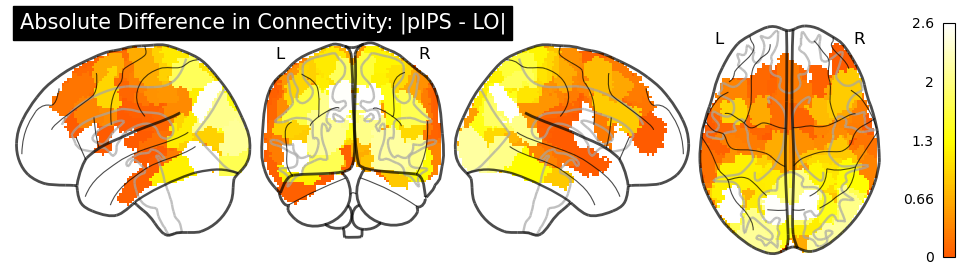

<Figure size 1200x400 with 0 Axes>

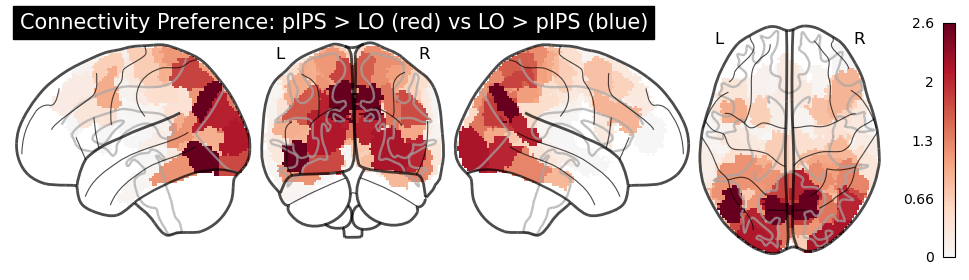

<Figure size 1200x500 with 0 Axes>

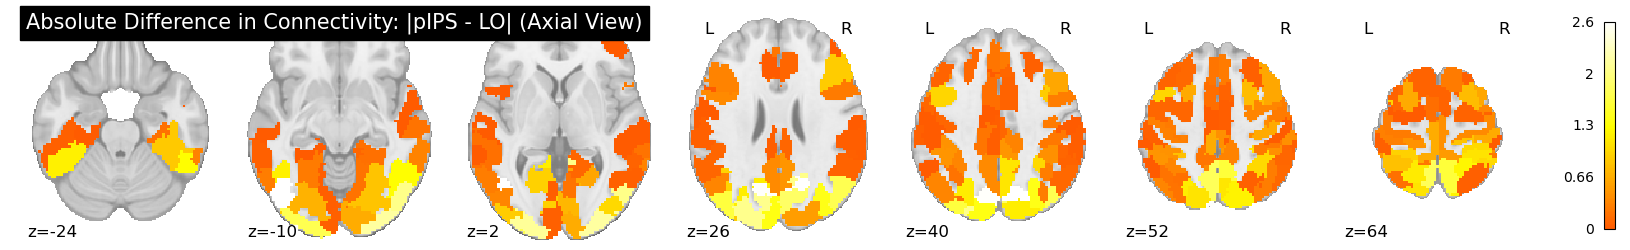

<Figure size 1200x500 with 0 Axes>

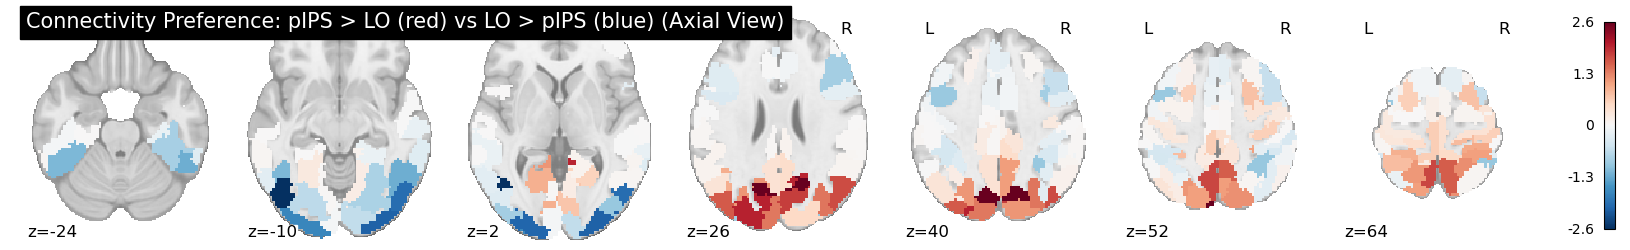

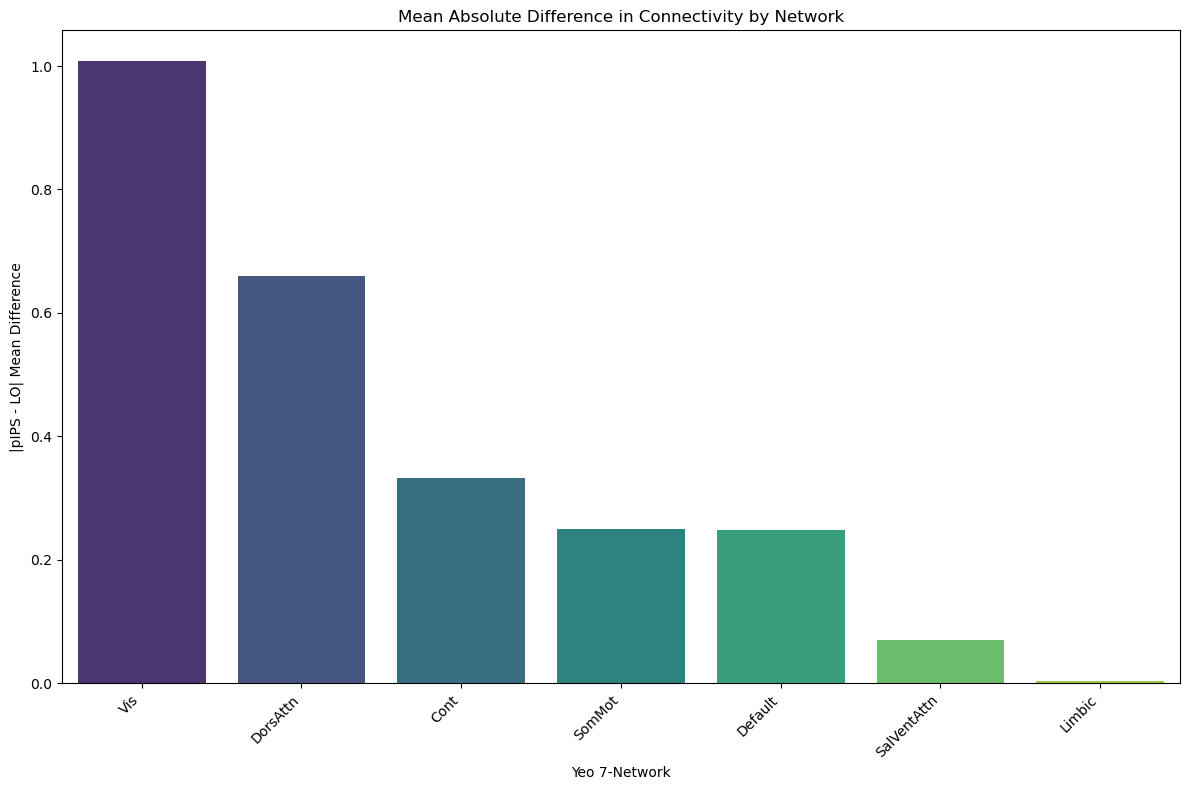

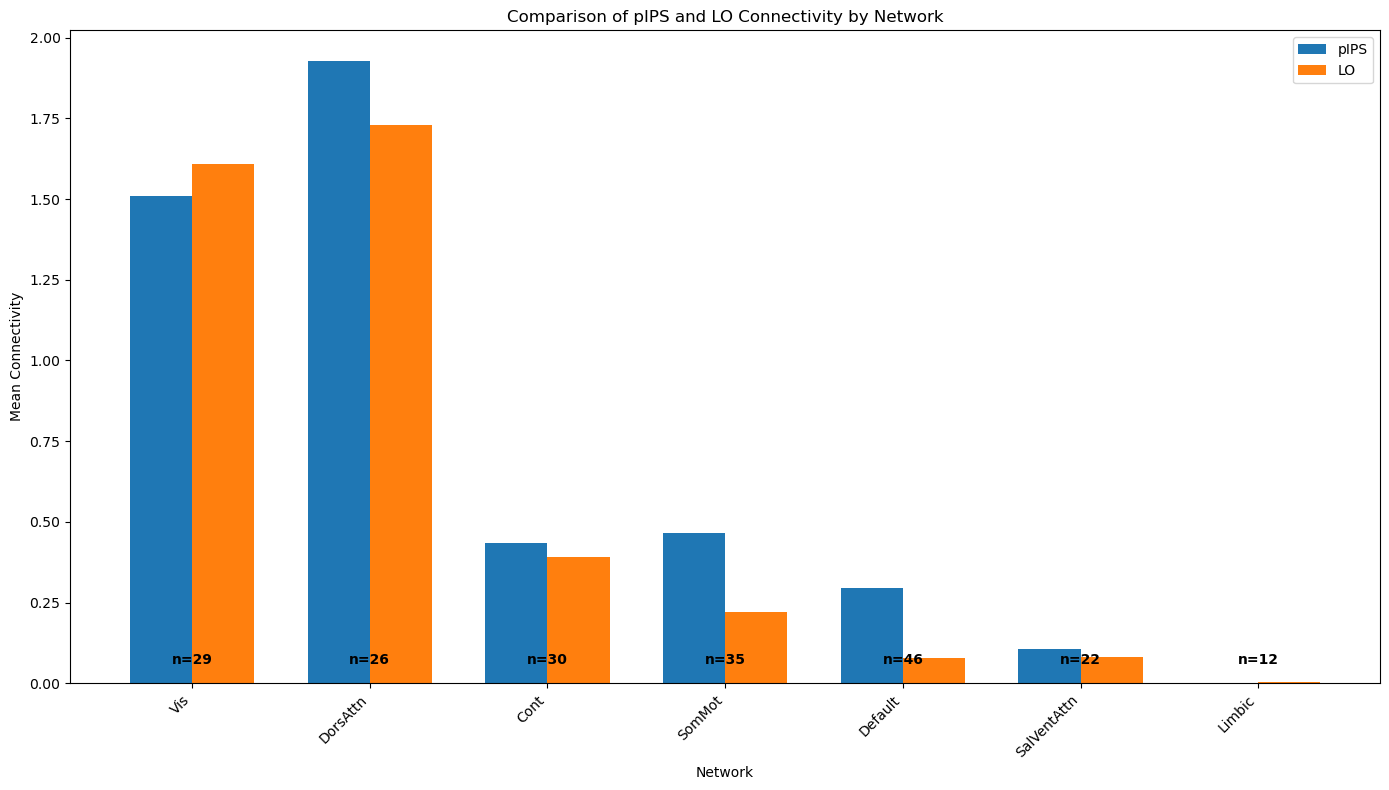

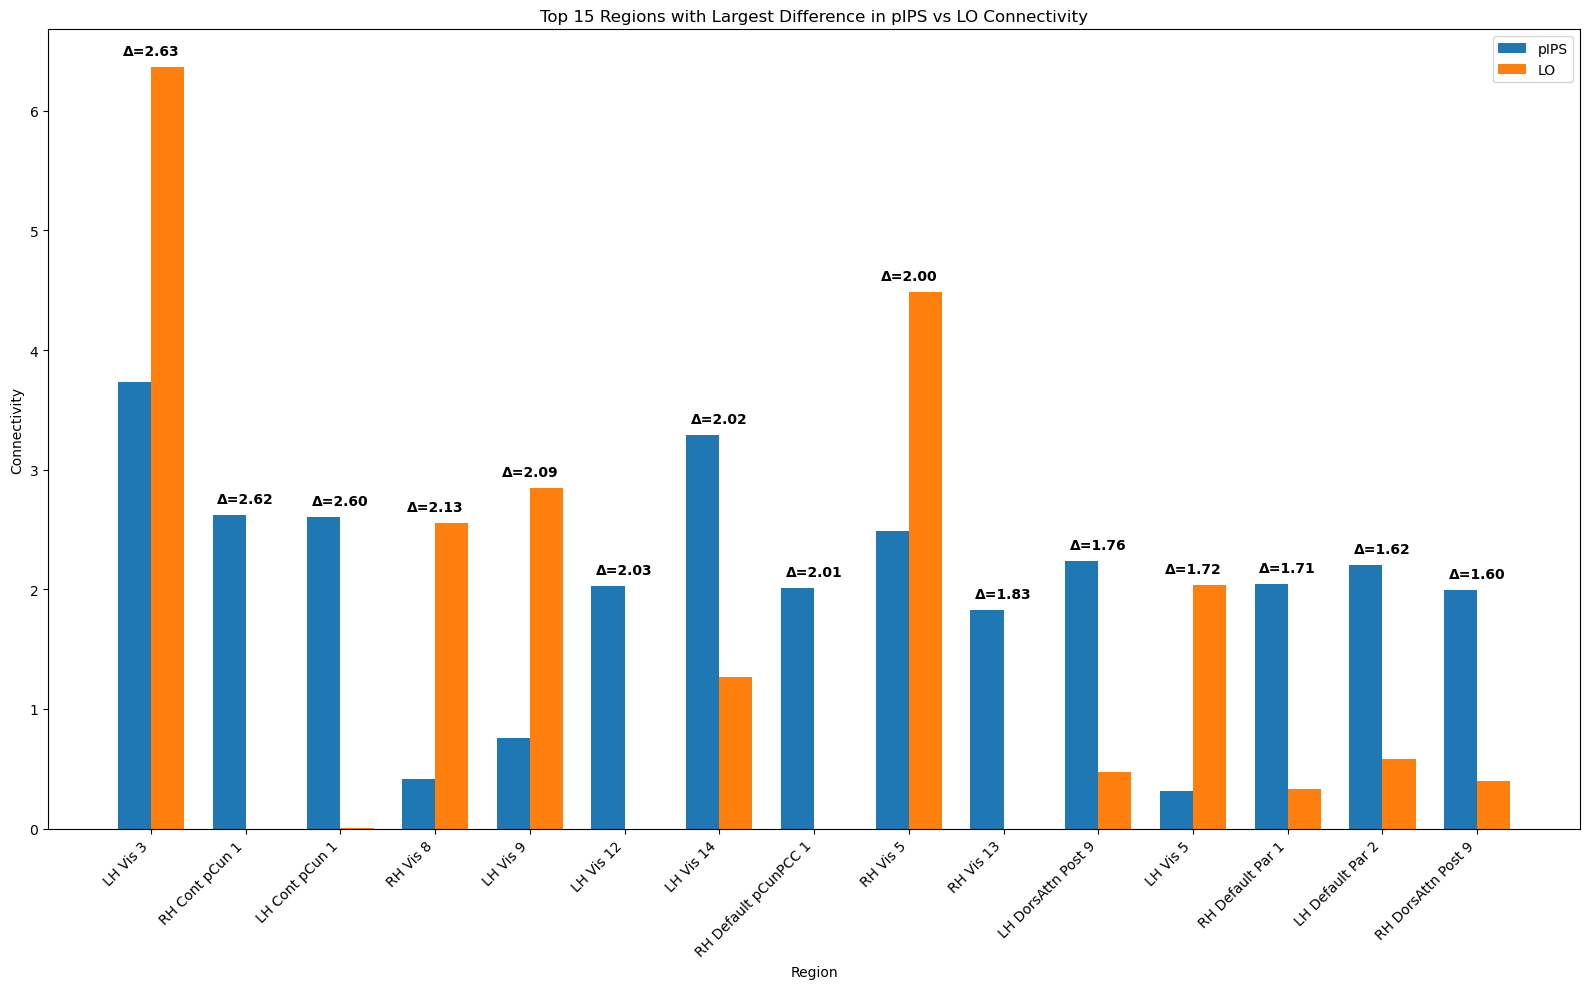

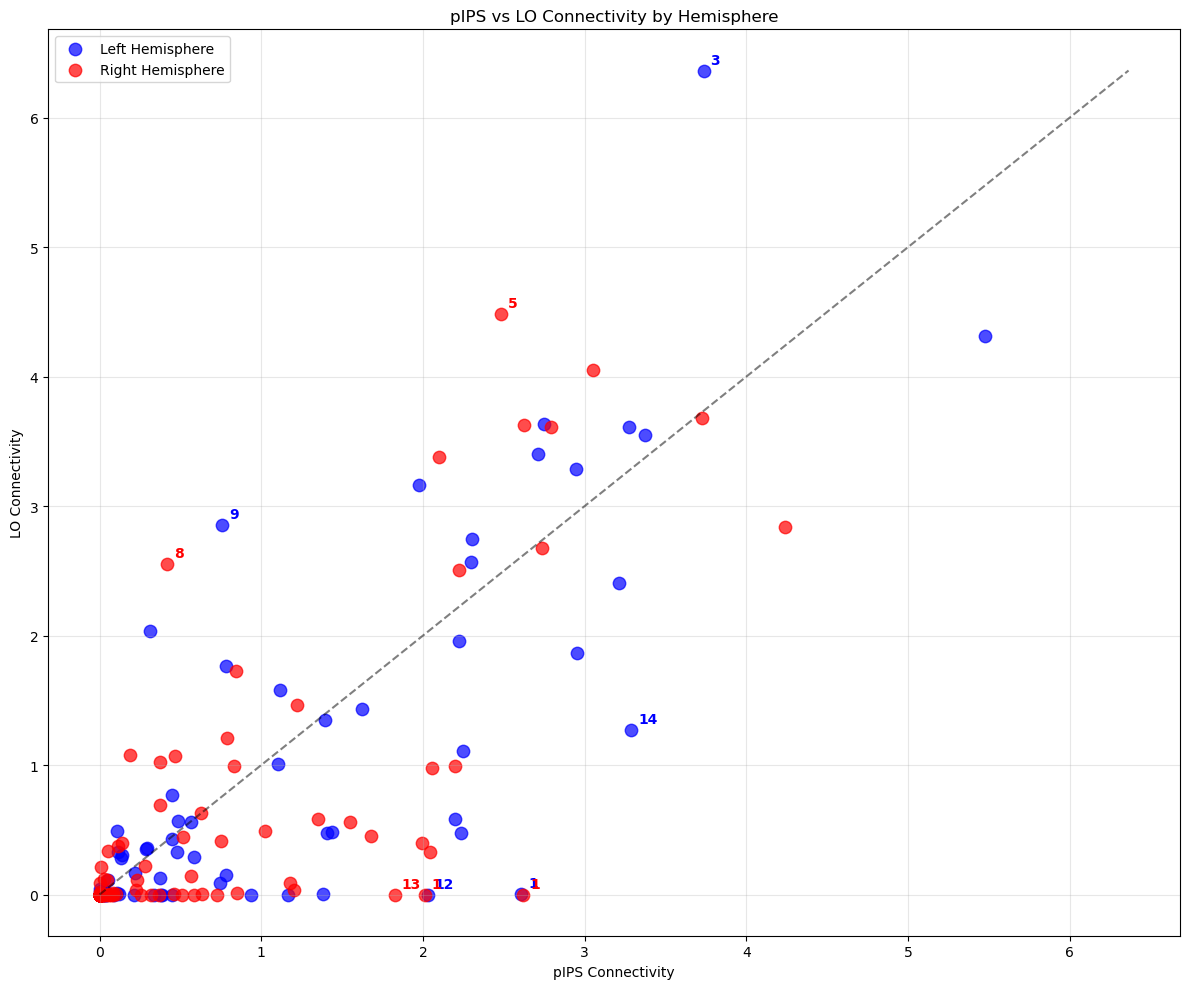

/tmp/ipykernel_5263/3798681972.py:341: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


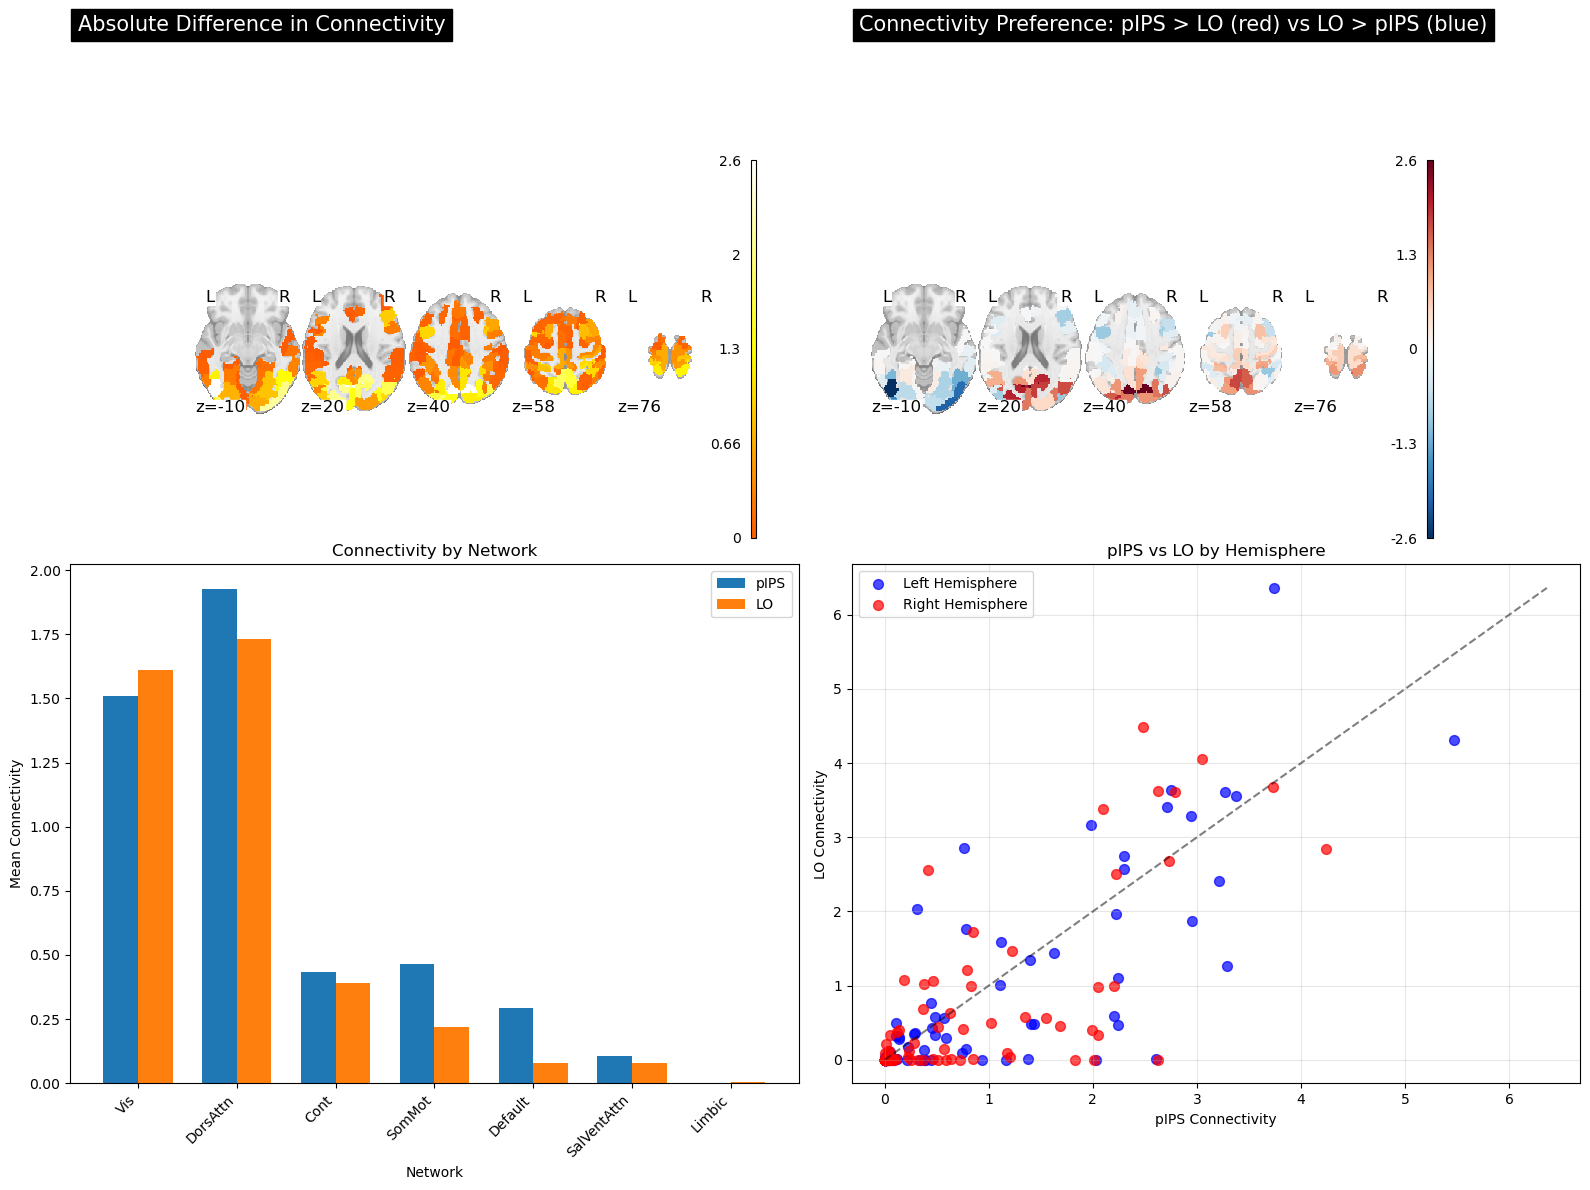

Visualization complete


<Figure size 1500x800 with 0 Axes>

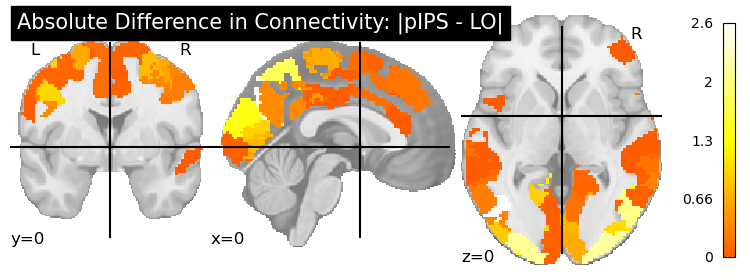

<Figure size 1500x800 with 0 Axes>

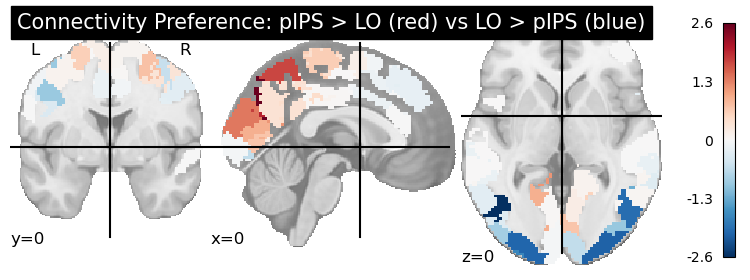

<Figure size 1500x1200 with 0 Axes>

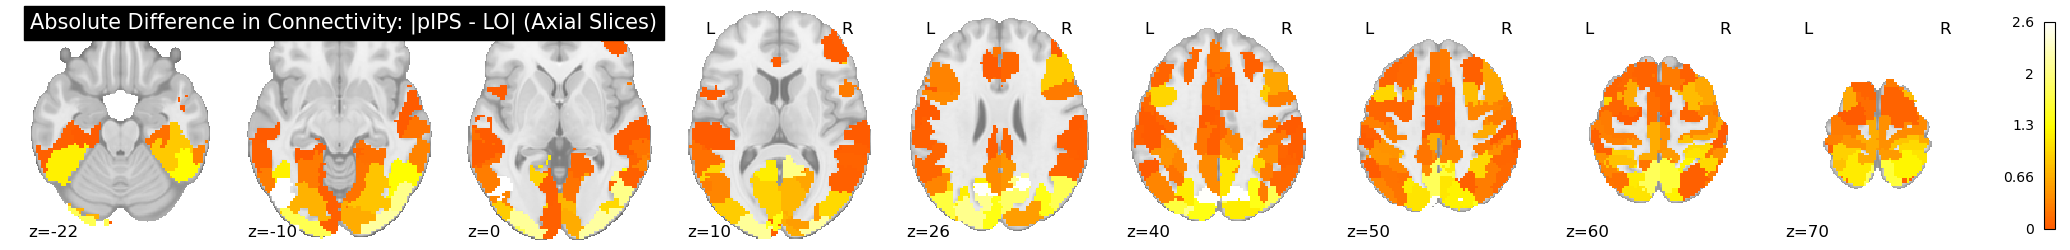

<Figure size 1500x1200 with 0 Axes>

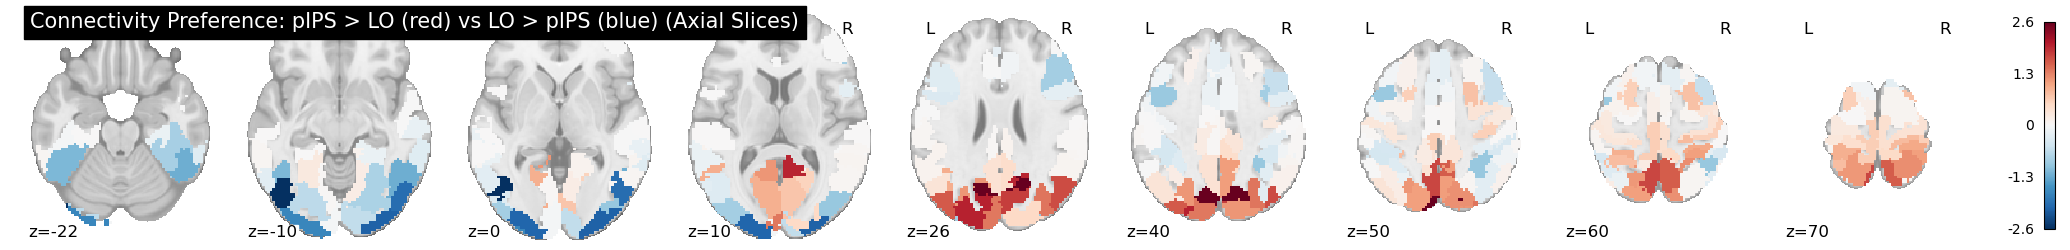

Multi-slice visualization complete

=== ANALYSIS SUMMARY BY NETWORK ===
Vis (n=29): pIPS = 1.5085, LO = 1.6091, diff = 1.0074
DorsAttn (n=26): pIPS = 1.9263, LO = 1.7298, diff = 0.6597
Cont (n=30): pIPS = 0.4339, LO = 0.3909, diff = 0.3320
SomMot (n=35): pIPS = 0.4641, LO = 0.2193, diff = 0.2504
Default (n=46): pIPS = 0.2947, LO = 0.0791, diff = 0.2481
SalVentAttn (n=22): pIPS = 0.1048, LO = 0.0804, diff = 0.0705
Limbic (n=12): pIPS = 0.0000, LO = 0.0034, diff = 0.0034


In [39]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, datasets, plotting, surface
from nilearn.maskers import NiftiLabelsMasker
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

# Define paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
roi_dir = f'{base_dir}/roiParcels'
results_dir = f'{base_dir}/results'
group_out_dir = f'{results_dir}/group_averages'

def create_connectivity_difference_map():
    """
    Create a brain map showing the difference in connectivity between pIPS and LO
    """
    print("Creating connectivity difference map...")
    
    # 1. Load the FC maps
    try:
        pIPS_img = nib.load(f'{group_out_dir}/pIPS_left_fc_thresh.nii.gz')
        LO_img = nib.load(f'{group_out_dir}/LO_left_fc_thresh.nii.gz')
        print("Successfully loaded FC maps")
    except FileNotFoundError as e:
        print(f"Error: Could not find FC maps: {e}")
        return None
    
    # 2. Load Schaefer atlas (without modifications)
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    atlas_labels = atlas.labels
    print(f"Loaded Schaefer atlas with {len(atlas_labels)} parcels")
    
    # 3. Create masker and extract values
    masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
    pIPS_values = masker.fit_transform(pIPS_img)[0]
    LO_values = masker.fit_transform(LO_img)[0]
    
    print(f"Extracted values - pIPS: {pIPS_values.shape}, LO: {LO_values.shape}")
    
    # 4. Calculate absolute differences
    diff_values = np.abs(pIPS_values - LO_values)
    
    # 5. Get region names
    region_names = []
    for i, label in enumerate(masker.labels_):
        label_idx = int(label) - 1  # Convert to 0-indexed
        if 0 <= label_idx < len(atlas_labels):
            name = atlas_labels[label_idx]
            name = name.decode('utf-8') if isinstance(name, bytes) else str(name)
            region_names.append(name)
        else:
            region_names.append(f"Region_{label}")
    
    # 6. Create a dataframe with region information
    region_df = pd.DataFrame({
        'Region': region_names,
        'Label': masker.labels_,
        'pIPS': pIPS_values,
        'LO': LO_values,
        'Difference': diff_values
    })
    
    # 7. Create a volume representing the differences
    diff_map_data = np.zeros_like(atlas_img.get_fdata())
    for i, label in enumerate(masker.labels_):
        diff_map_data[atlas_img.get_fdata() == label] = diff_values[i]
    
    diff_map = nib.Nifti1Image(diff_map_data, atlas_img.affine)
    
    # 8. Create a second map showing relative preference (positive for pIPS > LO, negative for LO > pIPS)
    preference_values = pIPS_values - LO_values
    pref_map_data = np.zeros_like(atlas_img.get_fdata())
    for i, label in enumerate(masker.labels_):
        pref_map_data[atlas_img.get_fdata() == label] = preference_values[i]
    
    pref_map = nib.Nifti1Image(pref_map_data, atlas_img.affine)
    
    # Save both maps
    diff_map_file = f'{results_dir}/pIPS_LO_abs_diff.nii.gz'
    pref_map_file = f'{results_dir}/pIPS_LO_preference.nii.gz'
    nib.save(diff_map, diff_map_file)
    nib.save(pref_map, pref_map_file)
    
    print(f"Saved difference maps to {results_dir}")
    
    return {
        'region_df': region_df,
        'diff_map': diff_map,
        'pref_map': pref_map,
        'atlas_img': atlas_img
    }

def visualize_connectivity_differences(map_data):
    """
    Create visualizations of connectivity differences between pIPS and LO
    """
    if map_data is None:
        print("No data to visualize")
        return
    
    region_df = map_data['region_df']
    diff_map = map_data['diff_map']
    pref_map = map_data['pref_map']
    
    # Skip surface plotting as it seems to be causing issues
    # Instead, use glass brain and statmap visualizations which are more reliable
    
    # 1. Glass brain visualization for absolute differences
    print("\nCreating brain visualizations...")
    plt.figure(figsize=(12, 4))
    plotting.plot_glass_brain(
        diff_map,
        display_mode='lyrz',
        colorbar=True,
        cmap='hot',
        title="Absolute Difference in Connectivity: |pIPS - LO|"
    )
    plt.savefig(f'{results_dir}/glass_brain_abs_diff.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Glass brain visualization for preference
    plt.figure(figsize=(12, 4))
    plotting.plot_glass_brain(
        pref_map,
        display_mode='lyrz',
        colorbar=True,
        cmap='RdBu_r',
        title="Connectivity Preference: pIPS > LO (red) vs LO > pIPS (blue)"
    )
    plt.savefig(f'{results_dir}/glass_brain_preference.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Stat map visualization (slices)
    plt.figure(figsize=(12, 5))
    plotting.plot_stat_map(
        diff_map,
        display_mode='z',
        cut_coords=7,
        colorbar=True,
        cmap='hot',
        title="Absolute Difference in Connectivity: |pIPS - LO| (Axial View)"
    )
    plt.savefig(f'{results_dir}/stat_map_abs_diff_axial.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plotting.plot_stat_map(
        pref_map,
        display_mode='z',
        cut_coords=7,
        colorbar=True,
        cmap='RdBu_r',
        title="Connectivity Preference: pIPS > LO (red) vs LO > pIPS (blue) (Axial View)"
    )
    plt.savefig(f'{results_dir}/stat_map_preference_axial.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Network-based analysis
    # Extract network information from region names
    region_df['Network'] = region_df['Region'].apply(
        lambda x: x.split('_')[2] if isinstance(x, str) and len(x.split('_')) > 2 else 'Unknown'
    )
    
    # Group by network and calculate means
    network_stats = region_df.groupby('Network').agg({
        'pIPS': 'mean',
        'LO': 'mean',
        'Difference': 'mean',
        'Region': 'count'
    }).rename(columns={'Region': 'Count'}).reset_index()
    
    # Sort by mean difference
    network_stats = network_stats.sort_values('Difference', ascending=False)
    
    # Bar plot of differences by network
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Network', y='Difference', data=network_stats, palette='viridis')
    plt.title('Mean Absolute Difference in Connectivity by Network')
    plt.xlabel('Yeo 7-Network')
    plt.ylabel('|pIPS - LO| Mean Difference')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{results_dir}/network_differences.png', dpi=300)
    plt.show()
    
    # 5. Network-based comparison of pIPS vs. LO
    plt.figure(figsize=(14, 8))
    
    # Create positions for grouped bar chart
    x = np.arange(len(network_stats))
    width = 0.35
    
    # Create grouped bar chart
    plt.bar(x - width/2, network_stats['pIPS'], width, label='pIPS')
    plt.bar(x + width/2, network_stats['LO'], width, label='LO')
    
    plt.xlabel('Network')
    plt.ylabel('Mean Connectivity')
    plt.title('Comparison of pIPS and LO Connectivity by Network')
    plt.xticks(x, network_stats['Network'], rotation=45, ha='right')
    plt.legend()
    
    # Add count labels above bars
    for i, count in enumerate(network_stats['Count']):
        plt.text(i, 0.05, f"n={count}", ha='center', va='bottom', color='black', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/network_comparison.png', dpi=300)
    plt.show()
    
    # 6. Plot the most different regions
    # Get top 15 most different regions
    top_diff = region_df.sort_values('Difference', ascending=False).head(15)
    top_diff['Region'] = top_diff['Region'].apply(
        lambda x: str(x).replace('7Networks_', '').replace('_', ' ')
    )
    
    plt.figure(figsize=(16, 10))
    x = np.arange(len(top_diff))
    width = 0.35
    
    plt.bar(x - width/2, top_diff['pIPS'], width, label='pIPS')
    plt.bar(x + width/2, top_diff['LO'], width, label='LO')
    
    plt.xlabel('Region')
    plt.ylabel('Connectivity')
    plt.title('Top 15 Regions with Largest Difference in pIPS vs LO Connectivity')
    plt.xticks(x, top_diff['Region'], rotation=45, ha='right')
    plt.legend()
    
    # Add difference value labels
    for i, diff in enumerate(top_diff['Difference']):
        plt.text(i, max(top_diff['pIPS'].iloc[i], top_diff['LO'].iloc[i]) + 0.1, 
                 f"Δ={diff:.2f}", ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/top_different_regions.png', dpi=300)
    plt.show()
    
    # 7. Create Schaefer-specific plot of hemispheres
    # First determine which regions are left vs right hemisphere
    region_df['Hemisphere'] = region_df['Region'].apply(
        lambda x: 'Left' if '_LH_' in str(x) or '_L_' in str(x) else 
                 ('Right' if '_RH_' in str(x) or '_R_' in str(x) else 'Unknown')
    )
    
    # Create a scatter plot with hemispheres colored differently
    plt.figure(figsize=(12, 10))
    
    # Filter for only left and right hemispheres (no unknown)
    left_regions = region_df[region_df['Hemisphere'] == 'Left']
    right_regions = region_df[region_df['Hemisphere'] == 'Right']
    
    # Create scatter plot
    plt.scatter(left_regions['pIPS'], left_regions['LO'], color='blue', 
                alpha=0.7, label='Left Hemisphere', s=80)
    plt.scatter(right_regions['pIPS'], right_regions['LO'], color='red',
                alpha=0.7, label='Right Hemisphere', s=80)
    
    # Add diagonal line
    min_val = min(region_df['pIPS'].min(), region_df['LO'].min())
    max_val = max(region_df['pIPS'].max(), region_df['LO'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    # Label some of the extreme points
    for df, color in [(left_regions, 'blue'), (right_regions, 'red')]:
        # Get most different regions
        most_diff = df.nlargest(5, 'Difference')
        for _, row in most_diff.iterrows():
            plt.annotate(
                row['Region'].split('_')[-1],  # Just the region number
                (row['pIPS'], row['LO']),
                xytext=(5, 5),
                textcoords='offset points',
                color=color,
                fontweight='bold'
            )
    
    plt.xlabel('pIPS Connectivity')
    plt.ylabel('LO Connectivity')
    plt.title('pIPS vs LO Connectivity by Hemisphere')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{results_dir}/hemisphere_scatter.png', dpi=300)
    plt.show()
    
    # 8. Create a combined multi-panel visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top left: Stat map of absolute differences
    plotting.plot_stat_map(
        diff_map,
        display_mode='z',
        cut_coords=5,
        colorbar=True,
        cmap='hot',
        axes=axes[0, 0],
        title="Absolute Difference in Connectivity"
    )
    
    # Top right: Stat map of preference
    plotting.plot_stat_map(
        pref_map,
        display_mode='z',
        cut_coords=5,
        colorbar=True,
        cmap='RdBu_r',
        axes=axes[0, 1],
        title="Connectivity Preference: pIPS > LO (red) vs LO > pIPS (blue)"
    )
    
    # Bottom left: Network comparison
    pos = np.arange(len(network_stats))
    axes[1, 0].bar(pos - width/2, network_stats['pIPS'], width, label='pIPS')
    axes[1, 0].bar(pos + width/2, network_stats['LO'], width, label='LO')
    axes[1, 0].set_xlabel('Network')
    axes[1, 0].set_ylabel('Mean Connectivity')
    axes[1, 0].set_title('Connectivity by Network')
    axes[1, 0].set_xticks(pos)
    axes[1, 0].set_xticklabels(network_stats['Network'], rotation=45, ha='right')
    axes[1, 0].legend()
    
    # Bottom right: Hemisphere scatter plot
    axes[1, 1].scatter(left_regions['pIPS'], left_regions['LO'], color='blue', 
                      alpha=0.7, label='Left Hemisphere', s=50)
    axes[1, 1].scatter(right_regions['pIPS'], right_regions['LO'], color='red',
                      alpha=0.7, label='Right Hemisphere', s=50)
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    axes[1, 1].set_xlabel('pIPS Connectivity')
    axes[1, 1].set_ylabel('LO Connectivity')
    axes[1, 1].set_title('pIPS vs LO by Hemisphere')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/combined_analysis.png', dpi=300)
    plt.show()
    
    print("Visualization complete")
    return network_stats

def visualize_3d_brain_with_differences(map_data):
    """
    Create multi-slice views instead of 3D brain
    """
    if map_data is None:
        print("No data to visualize")
        return
    
    diff_map = map_data['diff_map']
    pref_map = map_data['pref_map']
    
    # Multi-slice views for difference map
    plt.figure(figsize=(15, 8))
    plotting.plot_stat_map(
        diff_map,
        display_mode='ortho',
        colorbar=True,
        cmap='hot',
        cut_coords=(0, 0, 0),
        title="Absolute Difference in Connectivity: |pIPS - LO|"
    )
    plt.savefig(f'{results_dir}/multi_slice_diff.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Multi-slice views for preference map
    plt.figure(figsize=(15, 8))
    plotting.plot_stat_map(
        pref_map,
        display_mode='ortho',
        colorbar=True,
        cmap='RdBu_r',
        cut_coords=(0, 0, 0),
        title="Connectivity Preference: pIPS > LO (red) vs LO > pIPS (blue)"
    )
    plt.savefig(f'{results_dir}/multi_slice_pref.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Multiple axial slices for difference map
    plt.figure(figsize=(15, 12))
    plotting.plot_stat_map(
        diff_map,
        display_mode='z',
        colorbar=True,
        cmap='hot',
        cut_coords=9,  # 9 slices
        title="Absolute Difference in Connectivity: |pIPS - LO| (Axial Slices)"
    )
    plt.savefig(f'{results_dir}/axial_slices_diff.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Multiple axial slices for preference map
    plt.figure(figsize=(15, 12))
    plotting.plot_stat_map(
        pref_map,
        display_mode='z',
        colorbar=True,
        cmap='RdBu_r',
        cut_coords=9,  # 9 slices
        title="Connectivity Preference: pIPS > LO (red) vs LO > pIPS (blue) (Axial Slices)"
    )
    plt.savefig(f'{results_dir}/axial_slices_pref.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Multi-slice visualization complete")

# Run the visualization
if __name__ == "__main__":
    # Create connectivity difference map
    map_data = create_connectivity_difference_map()
    
    # Create visualizations
    if map_data is not None:
        network_stats = visualize_connectivity_differences(map_data)
        visualize_3d_brain_with_differences(map_data)
        
        print("\n=== ANALYSIS SUMMARY BY NETWORK ===")
        for _, row in network_stats.iterrows():
            print(f"{row['Network']} (n={int(row['Count'])}): " +
                 f"pIPS = {row['pIPS']:.4f}, LO = {row['LO']:.4f}, diff = {row['Difference']:.4f}")


Please specify which FC maps to use:
Available FC threshold maps in /user_data/csimmon2/git_repos/ptoc/results/group_averages:
  1. LO_right_fc_thresh.nii.gz
  2. LO_left_fc_thresh.nii.gz
  3. pIPS_left_fc_thresh.nii.gz
  4. pIPS_right_fc_thresh.nii.gz

Using default files:
  pIPS: pIPS_left_fc_thresh.nii.gz
  LO: LO_left_fc_thresh.nii.gz
Analyzing connectivity differences between pIPS and LO...
Using FC maps:
  pIPS: /user_data/csimmon2/git_repos/ptoc/results/group_averages/pIPS_left_fc_thresh.nii.gz
  LO: /user_data/csimmon2/git_repos/ptoc/results/group_averages/LO_left_fc_thresh.nii.gz
Successfully loaded FC maps
Loaded Schaefer atlas with 200 parcels
Extracted FC values - Shapes: pIPS (200,), LO (200,)
Overall correlation: r = 0.7638, p = 0.000000
Found 15 ROIs with statistically significant differences (|z| > 1.96)
Threshold for top 10% differences: 1.1871
Saved difference maps to /user_data/csimmon2/git_repos/ptoc/results

Creating ROI-level visualizations...


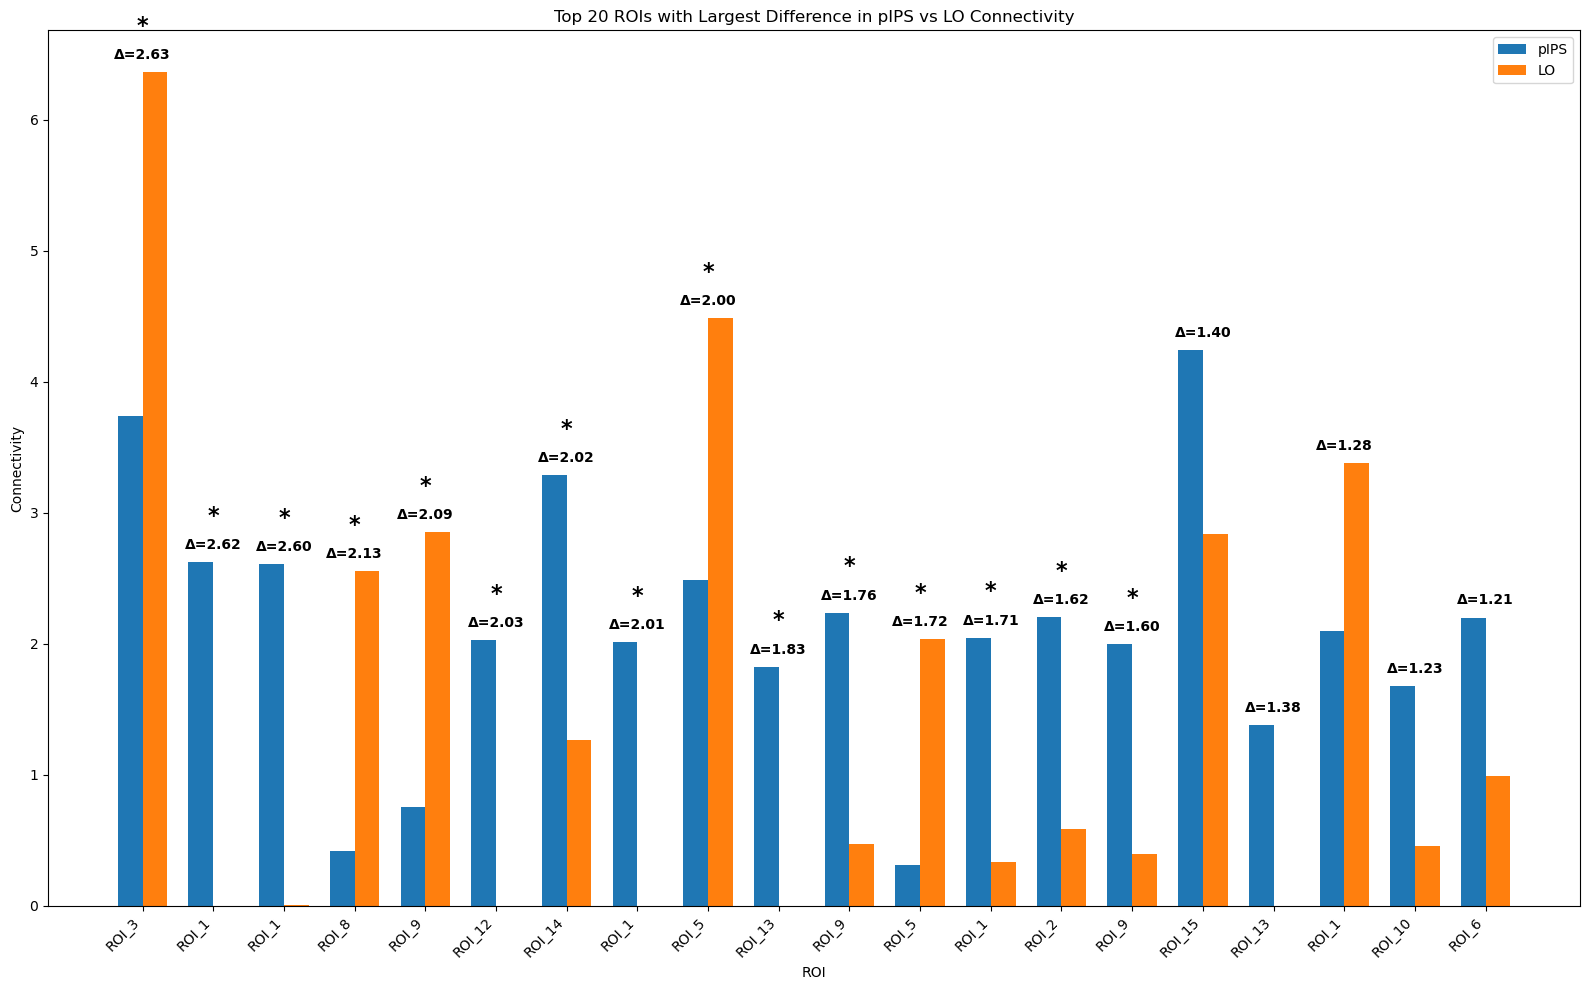

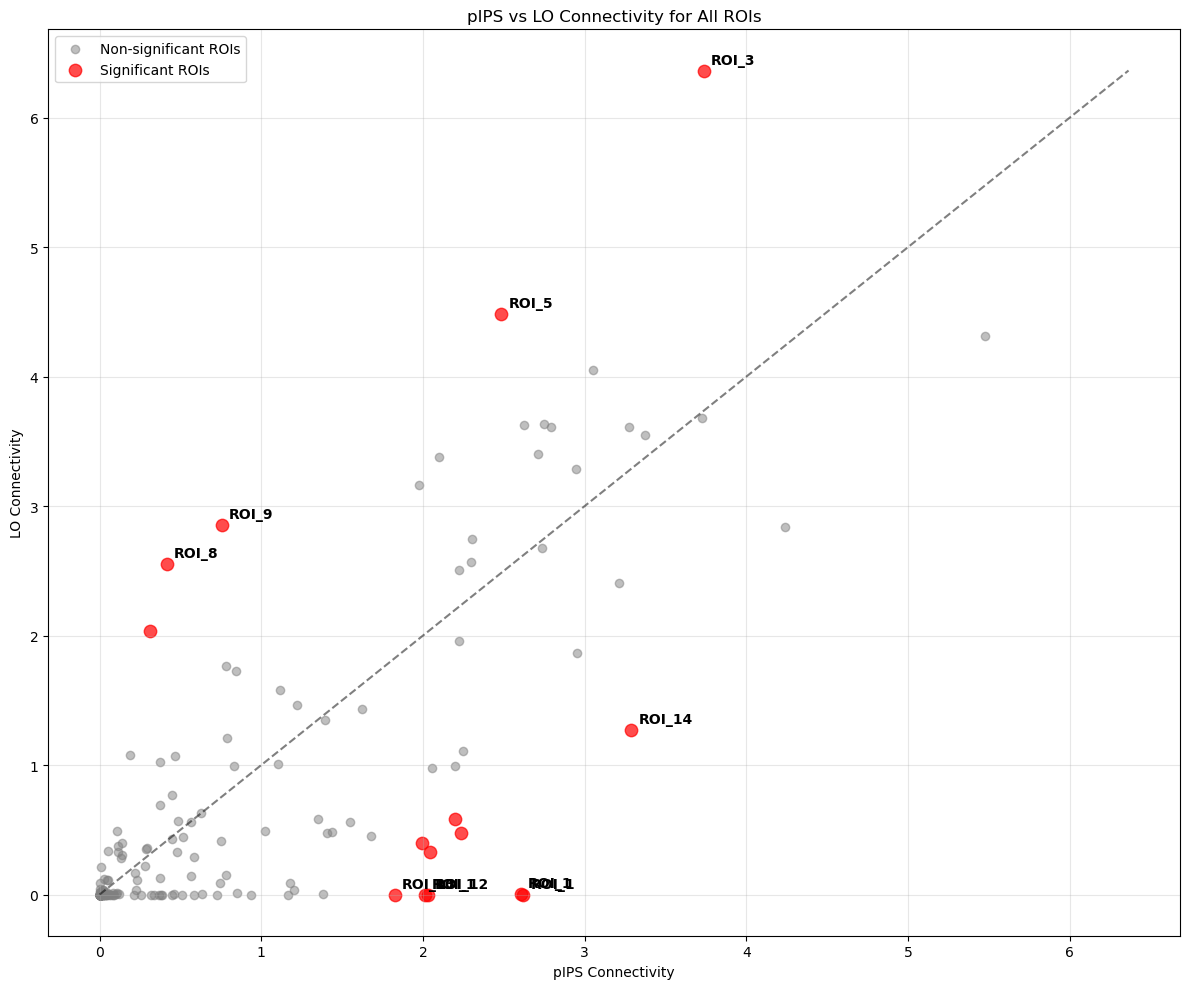

<Figure size 1200x400 with 0 Axes>

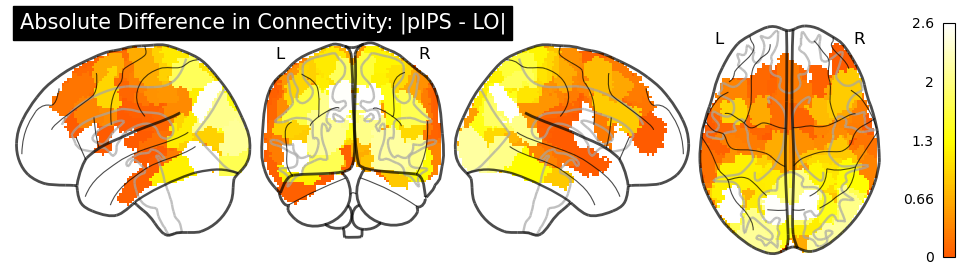

<Figure size 1200x500 with 0 Axes>

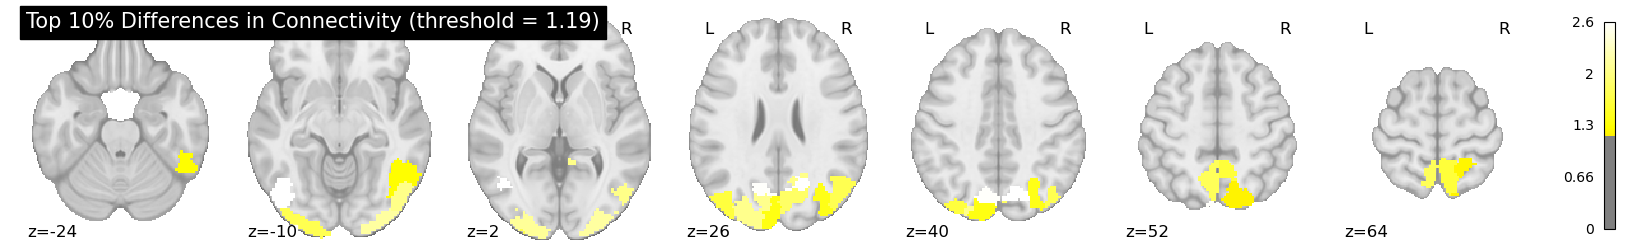

<Figure size 1200x500 with 0 Axes>

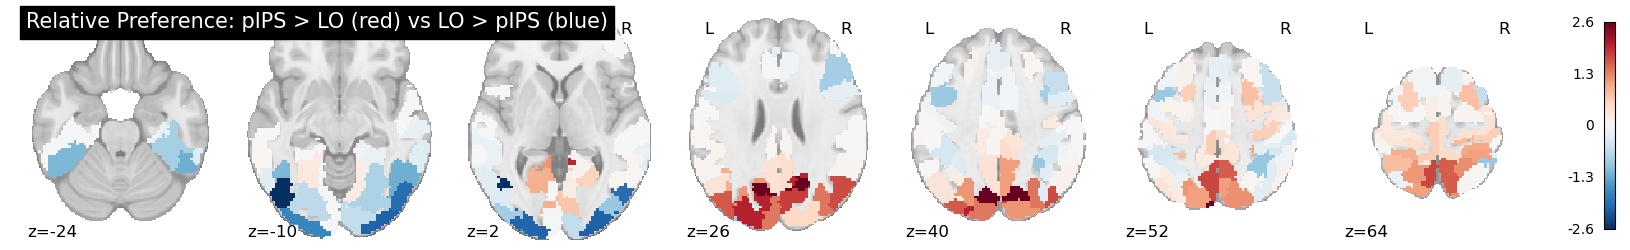

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


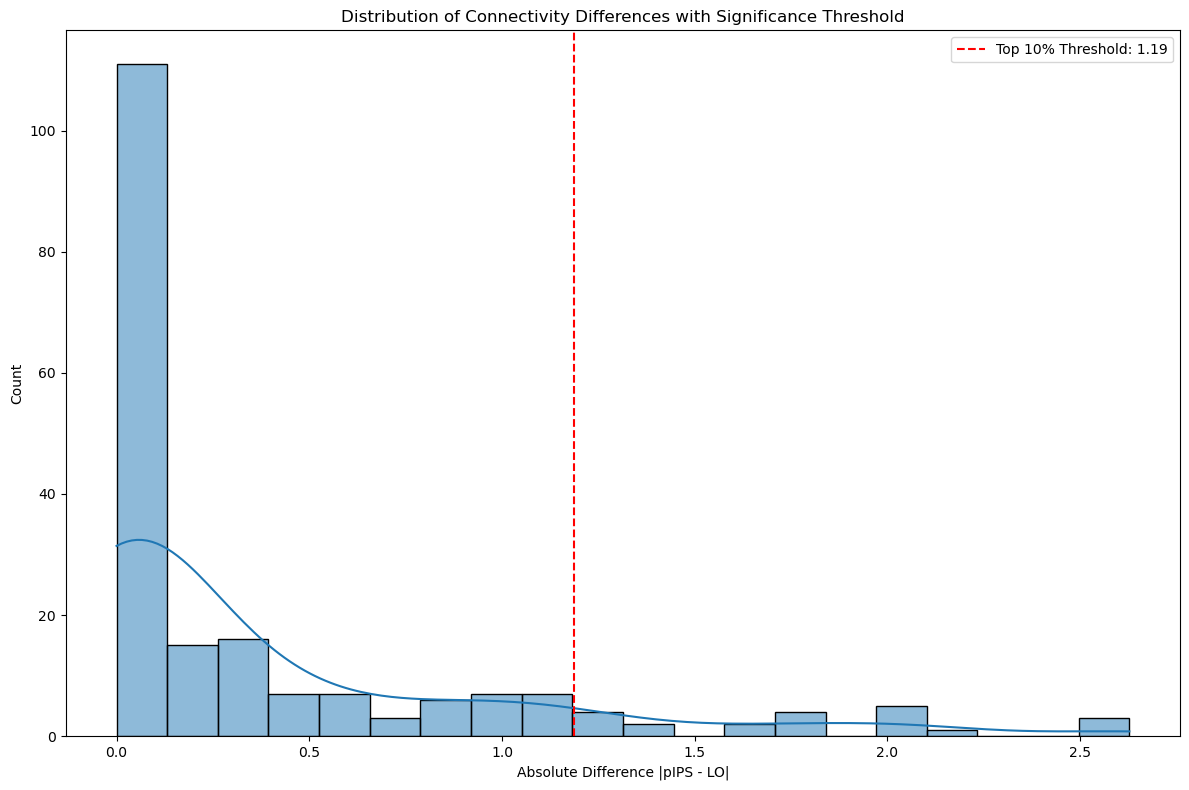

Saved detailed ROI statistics to /user_data/csimmon2/git_repos/ptoc/results/roi_connectivity_differences.csv
ROI visualizations complete

=== ANALYSIS SUMMARY ===
Correlation between pIPS and LO connectivity: r = 0.7638, p = 0.000000

Top 10 ROIs with largest differences:
3. ROI_3*: diff = 2.6275, pIPS = 3.7356, LO = 6.3631
177. ROI_1*: diff = 2.6209, pIPS = 2.6209, LO = 0.0000
71. ROI_1*: diff = 2.6013, pIPS = 2.6067, LO = 0.0054
108. ROI_8*: diff = 2.1344, pIPS = 0.4185, LO = 2.5528
9. ROI_9*: diff = 2.0925, pIPS = 0.7579, LO = 2.8504
12. ROI_12*: diff = 2.0297, pIPS = 2.0297, LO = 0.0000
14. ROI_14*: diff = 2.0209, pIPS = 3.2893, LO = 1.2683
198. ROI_1*: diff = 2.0103, pIPS = 2.0103, LO = 0.0000
105. ROI_5*: diff = 1.9998, pIPS = 2.4844, LO = 4.4842
113. ROI_13*: diff = 1.8254, pIPS = 1.8254, LO = 0.0000


In [40]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, norm
import seaborn as sns

# Define paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
roi_dir = f'{base_dir}/roiParcels'
results_dir = f'{base_dir}/results'
group_out_dir = f'{results_dir}/group_averages'
os.makedirs(results_dir, exist_ok=True)

def analyze_connectivity_differences(fc_maps=None):
    """
    Analyze connectivity differences between pIPS and LO without network categorization
    
    Parameters:
    -----------
    fc_maps : dict, optional
        Dictionary with custom file paths for FC maps, e.g., {'pIPS': '...', 'LO': '...'}
    """
    print("Analyzing connectivity differences between pIPS and LO...")
    
    # Default FC map files
    if fc_maps is None:
        fc_maps = {
            'pIPS': f'{group_out_dir}/pIPS_left_fc_thresh.nii.gz',
            'LO': f'{group_out_dir}/LO_left_fc_thresh.nii.gz'
        }
    
    # Check if files exist and print details
    print("Using FC maps:")
    for roi_name, fc_file in fc_maps.items():
        if os.path.exists(fc_file):
            print(f"  {roi_name}: {fc_file}")
        else:
            print(f"  Error: {roi_name} file not found: {fc_file}")
            return None
    
    # Load FC maps
    try:
        pIPS_img = nib.load(fc_maps['pIPS'])
        LO_img = nib.load(fc_maps['LO'])
        print("Successfully loaded FC maps")
    except Exception as e:
        print(f"Error loading FC maps: {e}")
        return None
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    atlas_labels = atlas.labels
    print(f"Loaded Schaefer atlas with {len(atlas_labels)} parcels")
    
    # Create masker and extract values
    masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
    pIPS_values = masker.fit_transform(pIPS_img)[0]
    LO_values = masker.fit_transform(LO_img)[0]
    
    print(f"Extracted FC values - Shapes: pIPS {pIPS_values.shape}, LO {LO_values.shape}")
    
    # Calculate absolute differences
    diff_values = np.abs(pIPS_values - LO_values)
    
    # Calculate relative difference (pIPS - LO)
    rel_diff_values = pIPS_values - LO_values
    
    # Get ROI numbers and clean up names
    roi_ids = []
    roi_names = []
    
    for i, label in enumerate(masker.labels_):
        label_idx = int(label) - 1  # Convert to 0-indexed
        if 0 <= label_idx < len(atlas_labels):
            # Get the full name
            full_name = atlas_labels[label_idx]
            full_name = full_name.decode('utf-8') if isinstance(full_name, bytes) else str(full_name)
            
            # Extract just the ROI number
            roi_number = full_name.split('_')[-1]
            
            # Store ID and simplified name
            roi_ids.append(int(label))
            roi_names.append(f"ROI_{roi_number}")
        else:
            roi_ids.append(int(label))
            roi_names.append(f"Unknown_{label}")
    
    # Create a dataframe with ROI information
    roi_df = pd.DataFrame({
        'ROI_ID': roi_ids,
        'ROI_Name': roi_names,
        'pIPS': pIPS_values,
        'LO': LO_values,
        'Abs_Difference': diff_values,
        'Rel_Difference': rel_diff_values
    })
    
    # Calculate the noise ceiling / threshold
    # Method 1: Z-score based threshold
    z_scores = (diff_values - np.mean(diff_values)) / np.std(diff_values)
    roi_df['Z_Score'] = z_scores
    
    # Consider differences significant if |z| > 1.96 (95% confidence)
    roi_df['Is_Significant'] = np.abs(roi_df['Z_Score']) > 1.96
    
    # Method 2: Percentile-based threshold (top 10%)
    threshold_percentile = 90
    threshold_value = np.percentile(diff_values, threshold_percentile)
    roi_df['Is_Top_10_Percent'] = roi_df['Abs_Difference'] >= threshold_value
    
    # Calculate overall correlation
    valid_mask = (pIPS_values != 0) & (LO_values != 0)
    if np.sum(valid_mask) > 1:
        correlation, p_value = pearsonr(pIPS_values[valid_mask], LO_values[valid_mask])
        print(f"Overall correlation: r = {correlation:.4f}, p = {p_value:.6f}")
    else:
        correlation, p_value = np.nan, np.nan
        print("Not enough valid data points for correlation analysis")
    
    # Count significant differences
    sig_count = roi_df['Is_Significant'].sum()
    print(f"Found {sig_count} ROIs with statistically significant differences (|z| > 1.96)")
    print(f"Threshold for top 10% differences: {threshold_value:.4f}")
    
    # Create volume maps
    diff_map_data = np.zeros_like(atlas_img.get_fdata())
    pref_map_data = np.zeros_like(atlas_img.get_fdata())
    
    for i, label in enumerate(masker.labels_):
        diff_map_data[atlas_img.get_fdata() == label] = diff_values[i]
        pref_map_data[atlas_img.get_fdata() == label] = rel_diff_values[i]
    
    diff_map = nib.Nifti1Image(diff_map_data, atlas_img.affine)
    pref_map = nib.Nifti1Image(pref_map_data, atlas_img.affine)
    
    # Save maps
    diff_map_file = f'{results_dir}/pIPS_LO_abs_diff.nii.gz'
    pref_map_file = f'{results_dir}/pIPS_LO_preference.nii.gz'
    nib.save(diff_map, diff_map_file)
    nib.save(pref_map, pref_map_file)
    
    print(f"Saved difference maps to {results_dir}")
    
    return {
        'roi_df': roi_df,
        'diff_map': diff_map,
        'pref_map': pref_map,
        'correlation': correlation,
        'p_value': p_value,
        'threshold_value': threshold_value
    }

def visualize_roi_differences(analysis_results):
    """
    Create visualizations focused on ROI-level differences without network grouping
    """
    if analysis_results is None:
        print("No data to visualize")
        return
    
    roi_df = analysis_results['roi_df']
    diff_map = analysis_results['diff_map']
    pref_map = analysis_results['pref_map']
    threshold_value = analysis_results['threshold_value']
    
    print("\nCreating ROI-level visualizations...")
    
    # 1. Top most different ROIs bar chart
    n_top = 20  # Show top 20 ROIs
    top_diff_rois = roi_df.sort_values('Abs_Difference', ascending=False).head(n_top)
    
    plt.figure(figsize=(16, 10))
    x = np.arange(len(top_diff_rois))
    width = 0.35
    
    plt.bar(x - width/2, top_diff_rois['pIPS'], width, label='pIPS')
    plt.bar(x + width/2, top_diff_rois['LO'], width, label='LO')
    
    plt.xlabel('ROI')
    plt.ylabel('Connectivity')
    plt.title(f'Top {n_top} ROIs with Largest Difference in pIPS vs LO Connectivity')
    plt.xticks(x, top_diff_rois['ROI_Name'], rotation=45, ha='right')
    plt.legend()
    
    # Add difference value labels
    for i, diff in enumerate(top_diff_rois['Abs_Difference']):
        plt.text(i, max(top_diff_rois['pIPS'].iloc[i], top_diff_rois['LO'].iloc[i]) + 0.1, 
                 f"Δ={diff:.2f}", ha='center', fontweight='bold')
        
        # Add asterisk for significant differences
        if top_diff_rois['Is_Significant'].iloc[i]:
            plt.text(i, max(top_diff_rois['pIPS'].iloc[i], top_diff_rois['LO'].iloc[i]) + 0.3, 
                     "*", ha='center', fontweight='bold', fontsize=16)
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/top_different_rois.png', dpi=300)
    plt.show()
    
    # 2. Scatter plot of all ROIs with significant differences highlighted
    plt.figure(figsize=(12, 10))
    
    # Plot non-significant points
    non_sig = roi_df[~roi_df['Is_Significant']]
    plt.scatter(non_sig['pIPS'], non_sig['LO'], color='gray', 
                alpha=0.5, label='Non-significant ROIs')
    
    # Plot significant points
    sig = roi_df[roi_df['Is_Significant']]
    plt.scatter(sig['pIPS'], sig['LO'], color='red',
                alpha=0.7, label='Significant ROIs', s=80)
    
    # Add diagonal line
    min_val = min(roi_df['pIPS'].min(), roi_df['LO'].min())
    max_val = max(roi_df['pIPS'].max(), roi_df['LO'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    # Label top different points
    for _, row in roi_df.nlargest(10, 'Abs_Difference').iterrows():
        plt.annotate(
            row['ROI_Name'],
            (row['pIPS'], row['LO']),
            xytext=(5, 5),
            textcoords='offset points',
            fontweight='bold'
        )
    
    plt.xlabel('pIPS Connectivity')
    plt.ylabel('LO Connectivity')
    plt.title('pIPS vs LO Connectivity for All ROIs')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{results_dir}/roi_scatter.png', dpi=300)
    plt.show()
    
    # 3. Brain visualizations - Glass brain for absolute differences
    plt.figure(figsize=(12, 4))
    plotting.plot_glass_brain(
        diff_map,
        display_mode='lyrz',
        colorbar=True,
        cmap='hot',
        title="Absolute Difference in Connectivity: |pIPS - LO|"
    )
    plt.savefig(f'{results_dir}/glass_brain_abs_diff.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Brain visualizations - Stat map with threshold for absolute differences
    plt.figure(figsize=(12, 5))
    plotting.plot_stat_map(
        diff_map,
        display_mode='z',
        cut_coords=7,
        colorbar=True,
        threshold=threshold_value,  # Only show top 10%
        cmap='hot',
        title=f"Top 10% Differences in Connectivity (threshold = {threshold_value:.2f})"
    )
    plt.savefig(f'{results_dir}/stat_map_threshold.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Brain visualizations - Preference map (pIPS > LO or LO > pIPS)
    plt.figure(figsize=(12, 5))
    plotting.plot_stat_map(
        pref_map,
        display_mode='z',
        cut_coords=7,
        colorbar=True,
        cmap='RdBu_r',
        title="Relative Preference: pIPS > LO (red) vs LO > pIPS (blue)"
    )
    plt.savefig(f'{results_dir}/stat_map_preference.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Distribution of differences with threshold
    plt.figure(figsize=(12, 8))
    sns.histplot(roi_df['Abs_Difference'], bins=20, kde=True)
    plt.axvline(x=threshold_value, color='r', linestyle='--', 
                label=f'Top 10% Threshold: {threshold_value:.2f}')
    plt.xlabel('Absolute Difference |pIPS - LO|')
    plt.ylabel('Count')
    plt.title('Distribution of Connectivity Differences with Significance Threshold')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{results_dir}/difference_distribution.png', dpi=300)
    plt.show()
    
    # 7. Save detailed ROI-level statistics to CSV
    csv_file = f'{results_dir}/roi_connectivity_differences.csv'
    roi_df.to_csv(csv_file, index=False)
    print(f"Saved detailed ROI statistics to {csv_file}")
    
    print("ROI visualizations complete")

def analyze_specified_fc_maps():
    """
    Prompt user for specific FC map files to use
    """
    print("\nPlease specify which FC maps to use:")
    
    # List all files in the group_out_dir
    all_files = []
    try:
        all_files = os.listdir(group_out_dir)
        fc_files = [f for f in all_files if f.endswith('_fc_thresh.nii.gz')]
        print(f"Available FC threshold maps in {group_out_dir}:")
        for i, f in enumerate(fc_files):
            print(f"  {i+1}. {f}")
    except Exception as e:
        print(f"Error listing files: {e}")
    
    # Default files
    default_maps = {
        'pIPS': f'{group_out_dir}/pIPS_left_fc_thresh.nii.gz',
        'LO': f'{group_out_dir}/LO_left_fc_thresh.nii.gz'
    }
    
    print(f"\nUsing default files:")
    for roi, file_path in default_maps.items():
        print(f"  {roi}: {os.path.basename(file_path)}")
    
    # Run the analysis with default maps
    results = analyze_connectivity_differences(default_maps)
    
    if results:
        visualize_roi_differences(results)
        
        # Print summary
        print("\n=== ANALYSIS SUMMARY ===")
        print(f"Correlation between pIPS and LO connectivity: r = {results['correlation']:.4f}, p = {results['p_value']:.6f}")
        
        # Summary of most different ROIs
        top_diff = results['roi_df'].nlargest(10, 'Abs_Difference')
        print("\nTop 10 ROIs with largest differences:")
        for i, row in top_diff.iterrows():
            sig_marker = "*" if row['Is_Significant'] else ""
            print(f"{i+1}. {row['ROI_Name']}{sig_marker}: diff = {row['Abs_Difference']:.4f}, " +
                 f"pIPS = {row['pIPS']:.4f}, LO = {row['LO']:.4f}")
    else:
        print("Analysis failed - check file paths and data")

# Run the main analysis function
if __name__ == "__main__":
    analyze_specified_fc_maps()